In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")
import torch
import numpy as np

import defmod as dm
import multimodule_usefulfunctions as mm 
import matplotlib.pyplot as plt
import defmod.hamiltonian_multishape as hamiltonian
import model_graddesc as model
import defmod.registrationdata as regdata

torch.set_default_tensor_type(torch.DoubleTensor)

In [2]:
data = regdata.organs()
data.build_modules()
data()
source = data.source
target = data.target

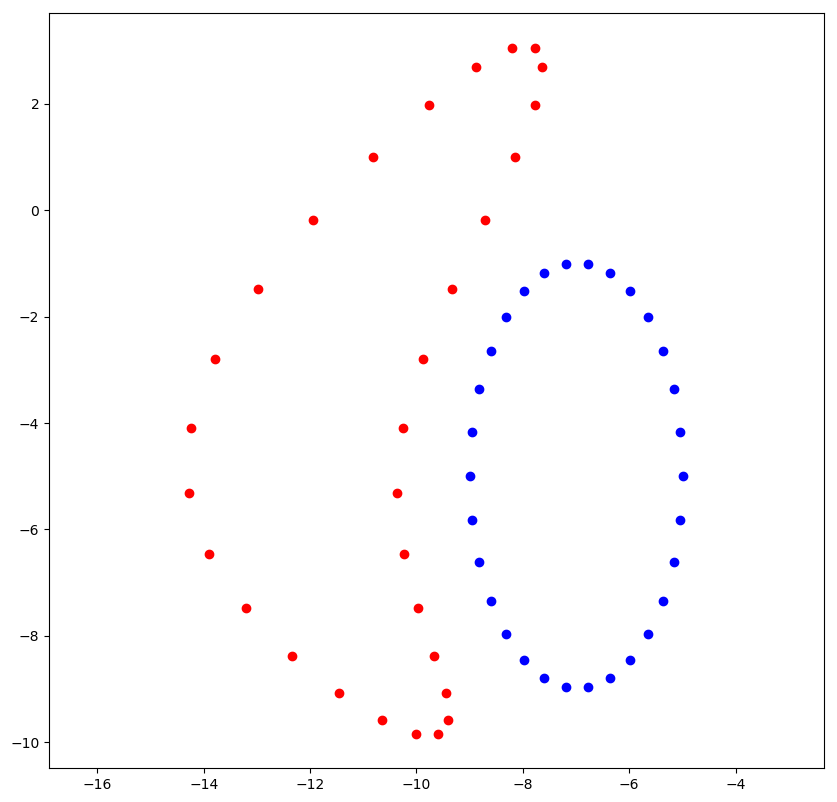

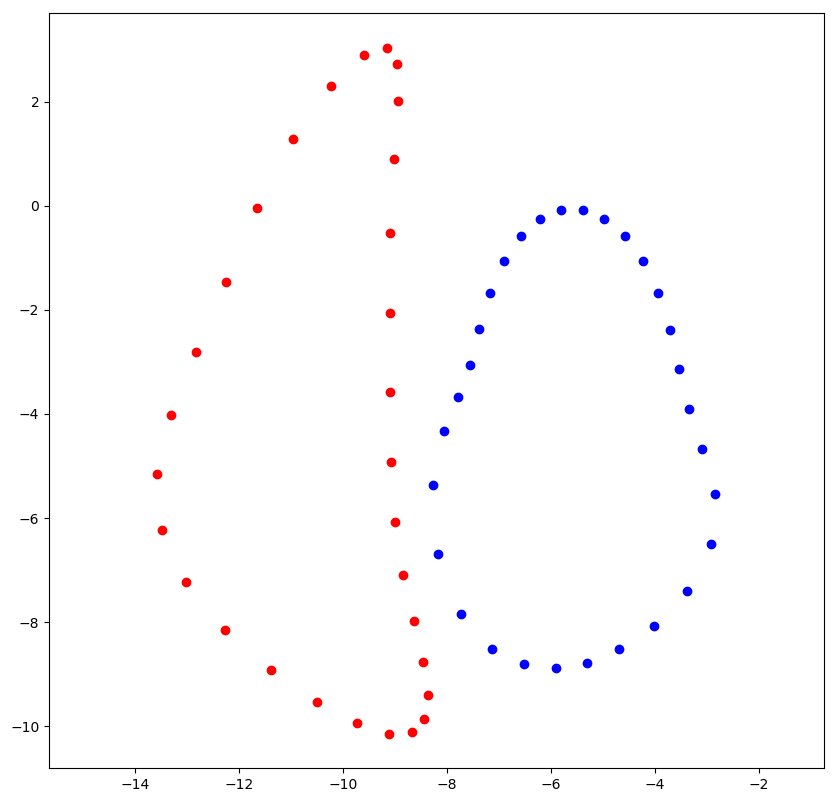

In [11]:
fig_source = plt.figure(figsize = (10,10), dpi=100)
plt.scatter(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), c='red')
plt.scatter(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), c='blue')
plt.axis('equal')

fig_target = plt.figure(figsize = (10,10), dpi=100)
plt.scatter(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), c='red')
plt.scatter(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), c='blue')

plt.axis('equal')
plt.show()

In [4]:
modules = dm.multishape.MultiShapeModule([data.modules[0], data.modules[1]])
modules.fill_controls_zero()
constr_Id = dm.constraints.Identity_Silent()
H = hamiltonian.Hamiltonian_multi(modules, constr_Id)

In [5]:
# set parameters
reg_param = 10**-3 

gd0_tensor = torch.cat(H.module.manifold.unroll_gd().copy(),0).requires_grad_().view(-1)
mom0_tensor = torch.cat(H.module.manifold.unroll_cotan().copy(),0).requires_grad_().view(-1)
    
gd0_tensor.retain_grad()
mom0_tensor.retain_grad()
    
EnergyFunctional = model.EnergyFunctional(modules, H, constr_Id,source, target, 2, reg_param)

# do registration
X = [gd0_tensor, mom0_tensor]
X = model.gradientdescent(EnergyFunctional, X)

energy: constraints_________________
tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [

cost: [ 0.00114817] attach: 14.242818831572475
c 0
 iter : 1  ,total energy: [ 14.243967]
energy: constraints_________________
tensor([[-1.3878e-17, -3.4694e-18],
        [ 1.7347e-17,  1.7347e-17],
        [ 2.0817e-17,  3.4694e-18],
        [-1.0408e-17, -1.7347e-18],
        [-1.3878e-17,  1.8648e-17],
        [-1.7347e-17,  3.7947e-18],
        [-3.1225e-17,  1.4745e-17],
        [-2.7756e-17,  1.3444e-17],
        [-3.1225e-17, -7.8063e-18],
        [-2.4286e-17,  5.2042e-18],
        [-2.0817e-17, -1.0408e-17],
        [ 0.0000e+00,  0.0000e+00],
        [-1.5613e-17, -3.4694e-18],
        [-1.2577e-17, -1.3878e-17],
        [ 3.4694e-18, -3.4694e-18],
        [ 1.3878e-17, -1.3878e-17],
        [ 1.0408e-17, -2.0817e-17],
        [ 1.7347e-17, -1.3878e-17],
        [ 0.0000e+00, -1.0408e-17],
        [ 3.4694e-18, -1.7347e-18],
        [ 1.7347e-17,  0.0000e+00],
        [ 3.4694e-18, -5.2042e-18],
        [ 3.4694e-18, -3.4694e-18],
        [ 1.3878e-17,  6.9389e-18],
        [

cost: [ 0.00641018] attach: 11.784952393127572
c 0
 iter : 3  ,total energy: [ 11.79136257]
energy: constraints_________________
tensor([[ 2.7756e-17, -2.7756e-17],
        [ 2.7756e-17,  0.0000e+00],
        [ 3.4694e-17,  4.8572e-17],
        [ 1.0408e-17,  1.3878e-17],
        [-2.0817e-17,  3.1225e-17],
        [-2.7756e-17,  4.5103e-17],
        [ 2.7756e-17,  1.8215e-17],
        [ 6.9389e-17,  8.6736e-18],
        [ 2.7756e-17,  5.2042e-17],
        [ 1.3878e-17,  3.4694e-18],
        [ 1.3878e-17,  2.7756e-17],
        [ 6.9389e-18,  6.2450e-17],
        [ 1.7347e-17, -1.3878e-17],
        [-1.2143e-17,  0.0000e+00],
        [ 1.3878e-17,  1.3878e-17],
        [ 1.3878e-17, -6.9389e-18],
        [ 1.3878e-17,  1.3878e-17],
        [ 0.0000e+00,  0.0000e+00],
        [ 1.3878e-17,  6.9389e-18],
        [ 0.0000e+00,  1.3878e-17],
        [ 6.9389e-18,  3.4694e-18],
        [ 0.0000e+00,  6.9389e-18],
        [-6.9389e-18, -1.0408e-17],
        [-2.7756e-17,  5.2042e-18],
       

cost: [ 0.01761966] attach: 9.758012130354034
c 0
 iter : 5  ,total energy: [ 9.77563179]
energy: constraints_________________
tensor([[-1.3878e-17,  0.0000e+00],
        [-5.5511e-17,  1.9429e-16],
        [ 4.1633e-17,  0.0000e+00],
        [ 2.7756e-17, -2.0817e-17],
        [-4.1633e-17,  7.6328e-17],
        [ 2.7756e-17,  3.7730e-17],
        [-5.5511e-17,  4.0766e-17],
        [ 8.3267e-17,  4.6838e-17],
        [ 2.7756e-17,  1.0061e-16],
        [-2.7756e-17,  3.4694e-17],
        [ 0.0000e+00,  2.7756e-17],
        [-2.7756e-17,  5.5511e-17],
        [ 1.3878e-17,  8.3267e-17],
        [-4.5103e-17,  1.3878e-16],
        [-2.7756e-17,  4.1633e-17],
        [-4.1633e-17,  2.7756e-17],
        [ 1.3878e-17,  6.9389e-17],
        [-2.7756e-17,  4.1633e-17],
        [-2.7756e-17,  4.1633e-17],
        [ 2.7756e-17,  2.7756e-17],
        [-5.5511e-17,  0.0000e+00],
        [ 0.0000e+00,  4.1633e-17],
        [-1.3878e-17,  3.4694e-18],
        [-2.7756e-17,  3.4694e-17],
        [

cost: [ 0.02360817] attach: 9.302947861516259
c 0
 iter : 7  ,total energy: [ 9.32655604]
energy: constraints_________________
tensor([[-2.7756e-17,  2.7756e-17],
        [ 5.5511e-17,  5.5511e-17],
        [ 0.0000e+00,  1.3878e-17],
        [ 0.0000e+00, -2.0123e-16],
        [ 0.0000e+00,  3.4694e-18],
        [-5.5511e-17,  5.0307e-17],
        [-5.5511e-17, -3.2960e-17],
        [-2.7756e-17, -7.0256e-17],
        [ 5.5511e-17, -7.6328e-17],
        [-2.7756e-17,  2.7756e-17],
        [-2.7756e-17, -6.9389e-17],
        [ 0.0000e+00,  2.7756e-17],
        [ 1.3184e-16,  0.0000e+00],
        [-1.7347e-17, -8.3267e-17],
        [ 5.5511e-17, -5.5511e-17],
        [ 8.3267e-17, -5.5511e-17],
        [ 2.7756e-17,  0.0000e+00],
        [ 8.3267e-17, -2.7756e-17],
        [-5.5511e-17,  5.5511e-17],
        [ 2.7756e-17, -5.5511e-17],
        [ 2.7756e-17,  1.3878e-17],
        [ 2.7756e-17, -1.3878e-17],
        [-2.7756e-17, -1.3878e-17],
        [-5.5511e-17,  5.5511e-17],
        [

cost: [ 0.02555303] attach: 8.89825063698445
c 0
 iter : 9  ,total energy: [ 8.92380366]
energy: constraints_________________
tensor([[-1.6653e-16,  1.9429e-16],
        [-2.2204e-16,  5.5511e-17],
        [ 1.1796e-16,  5.5511e-17],
        [-4.1633e-17,  9.7145e-17],
        [ 2.7756e-17,  4.8572e-17],
        [-5.5511e-17,  1.4572e-16],
        [-2.2204e-16,  1.0929e-16],
        [ 0.0000e+00,  2.6021e-17],
        [-2.7756e-16, -6.9389e-18],
        [-1.1102e-16, -2.7756e-17],
        [-1.6653e-16, -1.6653e-16],
        [-1.1102e-16,  5.5511e-17],
        [ 9.7145e-17,  5.5511e-17],
        [ 0.0000e+00,  1.1102e-16],
        [ 0.0000e+00,  0.0000e+00],
        [-8.3267e-17, -5.5511e-17],
        [-1.1102e-16,  0.0000e+00],
        [ 2.7756e-17,  8.3267e-17],
        [-1.3878e-16,  8.3267e-17],
        [ 0.0000e+00,  0.0000e+00],
        [ 5.5511e-17,  1.3878e-17],
        [ 0.0000e+00, -1.3878e-17],
        [ 5.5511e-17,  0.0000e+00],
        [-2.2204e-16,  1.1102e-16],
        [-

cost: [ 0.02988411] attach: 8.319300526304371
c 0
 iter : 11  ,total energy: [ 8.34918463]
energy: constraints_________________
tensor([[-3.3307e-16,  5.5511e-17],
        [-3.3307e-16,  5.5511e-17],
        [-1.8041e-16,  2.7756e-16],
        [-5.5511e-17,  4.4409e-16],
        [-3.3307e-16,  1.7347e-16],
        [-1.6653e-16,  1.3878e-16],
        [ 1.1102e-16,  4.1980e-16],
        [ 2.2204e-16, -5.4644e-17],
        [-1.1102e-16,  3.5388e-16],
        [-1.1102e-16,  1.6653e-16],
        [-3.3307e-16,  1.6653e-16],
        [ 5.5511e-17, -3.3307e-16],
        [-5.5511e-17,  2.2204e-16],
        [-1.3878e-16,  2.2204e-16],
        [ 0.0000e+00,  2.2204e-16],
        [-2.2204e-16,  2.7756e-16],
        [-1.1102e-16,  1.1102e-16],
        [-1.1102e-16,  5.5511e-17],
        [-1.6653e-16, -1.1102e-16],
        [-1.1102e-16,  5.5511e-17],
        [-1.1102e-16,  1.1102e-16],
        [-5.5511e-17,  2.7756e-17],
        [ 0.0000e+00, -6.9389e-17],
        [-1.1102e-16,  6.9389e-17],
        

cost: [ 0.03914135] attach: 7.494909577664435
c 0
 iter : 13  ,total energy: [ 7.53405093]
energy: constraints_________________
tensor([[ 6.6613e-16, -1.1102e-16],
        [ 2.2204e-16, -1.1102e-16],
        [ 1.3878e-16, -4.4409e-16],
        [ 3.3307e-16, -1.6653e-16],
        [ 0.0000e+00,  6.9389e-18],
        [ 0.0000e+00, -3.4694e-18],
        [-1.1102e-16, -1.0408e-17],
        [ 2.2204e-16, -2.1858e-16],
        [ 2.2204e-16,  8.3267e-17],
        [ 0.0000e+00,  1.6653e-16],
        [ 0.0000e+00,  2.2204e-16],
        [ 1.1102e-16,  1.1102e-16],
        [ 4.7184e-16, -2.2204e-16],
        [ 1.1102e-16, -3.3307e-16],
        [ 2.2204e-16,  1.1102e-16],
        [ 3.3307e-16, -2.2204e-16],
        [ 3.3307e-16, -3.3307e-16],
        [ 0.0000e+00, -1.6653e-16],
        [ 2.2204e-16, -1.6653e-16],
        [ 1.1102e-16, -5.5511e-17],
        [ 2.2204e-16, -5.5511e-17],
        [ 0.0000e+00, -5.5511e-17],
        [ 2.2204e-16, -1.3878e-16],
        [ 1.1102e-16, -1.3878e-16],
        

cost: [ 0.05902627] attach: 6.334903986879806
c 0
 iter : 15  ,total energy: [ 6.39393025]
energy: constraints_________________
tensor([[ 4.4409e-16,  2.2204e-16],
        [ 4.4409e-16,  1.1102e-16],
        [ 9.1593e-16, -4.4409e-16],
        [-2.2204e-16, -3.3307e-16],
        [ 2.2204e-16,  4.3021e-16],
        [ 2.2204e-16,  9.6798e-16],
        [ 4.4409e-16,  4.3021e-16],
        [ 6.6613e-16, -6.9389e-17],
        [ 4.4409e-16,  2.4980e-16],
        [-2.2204e-16,  4.4409e-16],
        [ 4.4409e-16,  0.0000e+00],
        [ 4.4409e-16, -4.4409e-16],
        [-2.7756e-16, -2.2204e-16],
        [ 1.9429e-16,  8.8818e-16],
        [ 1.1102e-16,  4.4409e-16],
        [-1.1102e-16,  4.4409e-16],
        [ 0.0000e+00, -1.1102e-16],
        [ 2.2204e-16,  4.4409e-16],
        [-3.3307e-16,  2.2204e-16],
        [-3.3307e-16,  1.6653e-16],
        [-2.2204e-16,  1.1102e-16],
        [-3.3307e-16,  1.6653e-16],
        [ 1.1102e-16,  1.6653e-16],
        [ 0.0000e+00,  5.5511e-17],
        

cost: [ 0.12396247] attach: 6.7107316170355915
Condition 0: tensor([1], dtype=torch.uint8)
Condition 1, 2, 3: tensor([1], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: False
c 1
 iter : 17  ,total energy: [ 6.83469409]
energy: constraints_________________
tensor([[-6.6613e-16, -6.6613e-16],
        [ 4.4409e-16,  3.3307e-16],
        [-6.6613e-16,  6.6613e-16],
        [-1.6653e-16,  1.6653e-16],
        [-4.4409e-16,  9.8532e-16],
        [ 0.0000e+00,  5.2042e-16],
        [-4.4409e-16, -5.5511e-17],
        [-2.2204e-16, -7.2858e-16],
        [ 0.0000e+00, -9.4369e-16],
        [-8.8818e-16,  4.9960e-16],
        [-8.8818e-16, -1.1102e-16],
        [-7.7716e-16, -2.2204e-16],
        [-4.9960e-16, -2.2204e-16],
        [ 2.7756e-17,  2.2204e-16],
        [ 0.0000e+00,  2.2204e-16],
        [-3.3307e-16, -2.2204e-16],
        [ 2.2204e-16,  2.2204e-16],
        [ 1.1102e-16,  2.2204e-16],
        

cost: [ 0.07920729] attach: 7.4895289697566705
Condition 0: tensor([1], dtype=torch.uint8)
Condition 1, 2, 3: tensor([1], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: False
c 1
 iter : 19  ,total energy: [ 7.56873626]
energy: constraints_________________
tensor([[ 2.2204e-16,  2.2204e-16],
        [ 7.7716e-16, -4.4409e-16],
        [ 5.5511e-16,  2.2204e-16],
        [ 8.3267e-16, -1.1102e-16],
        [ 5.5511e-16,  9.2981e-16],
        [ 4.4409e-16,  3.8164e-16],
        [-1.1102e-15,  4.9266e-16],
        [ 4.4409e-16,  7.4246e-16],
        [-4.4409e-16, -5.5511e-17],
        [ 0.0000e+00,  8.3267e-16],
        [ 4.4409e-16,  5.5511e-16],
        [-2.2204e-16, -4.4409e-16],
        [ 8.8818e-16, -4.4409e-16],
        [ 3.0531e-16, -1.3323e-15],
        [-1.1102e-16, -1.1102e-15],
        [ 3.3307e-16, -2.2204e-16],
        [ 3.3307e-16,  0.0000e+00],
        [ 2.2204e-16,  4.4409e-16],
        

cost: [ 0.11522685] attach: 5.428188326266536
Condition 0: tensor([1], dtype=torch.uint8)
Condition 1, 2, 3: tensor([1], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: False
c 1
 iter : 21  ,total energy: [ 5.54341518]
energy: constraints_________________
tensor([[-2.2204e-16,  4.4409e-16],
        [ 0.0000e+00,  2.2204e-16],
        [-6.6613e-16,  0.0000e+00],
        [ 0.0000e+00,  2.7756e-16],
        [-4.4409e-16, -1.8041e-16],
        [-6.6613e-16,  8.8124e-16],
        [-8.8818e-16,  1.5266e-16],
        [-2.2204e-16,  1.0165e-15],
        [-4.4409e-16, -1.9429e-16],
        [-6.6613e-16,  7.2164e-16],
        [-2.2204e-16,  1.2212e-15],
        [ 2.2204e-16, -2.2204e-16],
        [ 5.5511e-17,  2.2204e-16],
        [-3.8858e-16,  4.4409e-16],
        [ 1.1102e-16,  4.4409e-16],
        [-2.2204e-16, -4.4409e-16],
        [-3.3307e-16, -2.2204e-16],
        [ 0.0000e+00, -1.1102e-16],
        [

cost: [ 0.10077373] attach: 4.624677428593732
c 0
 iter : 23  ,total energy: [ 4.72545116]
energy: constraints_________________
tensor([[-4.4409e-16, -8.8818e-16],
        [-4.4409e-16, -1.1102e-16],
        [-2.2204e-16, -5.5511e-16],
        [-5.5511e-17,  2.2204e-16],
        [-4.4409e-16,  9.7145e-17],
        [-1.1102e-15, -2.2898e-16],
        [-2.2204e-16,  2.3592e-16],
        [-2.2204e-16, -5.1348e-16],
        [-2.2204e-16,  2.7756e-17],
        [ 0.0000e+00, -1.2768e-15],
        [-6.6613e-16, -8.8818e-16],
        [-6.6613e-16, -6.6613e-16],
        [-1.1102e-16,  0.0000e+00],
        [-2.7756e-16, -8.8818e-16],
        [ 2.2204e-16,  2.2204e-16],
        [ 4.4409e-16, -2.2204e-16],
        [ 4.4409e-16,  2.2204e-16],
        [-2.2204e-16,  2.2204e-16],
        [-2.2204e-16, -1.1102e-16],
        [-2.2204e-16,  4.4409e-16],
        [ 0.0000e+00,  0.0000e+00],
        [-4.4409e-16, -2.2204e-16],
        [-2.2204e-16, -2.2204e-16],
        [-2.2204e-16, -1.1102e-16],
        

cost: [ 0.11449382] attach: 4.214641702571509
c 0
 iter : 25  ,total energy: [ 4.32913553]
energy: constraints_________________
tensor([[-1.1102e-15,  0.0000e+00],
        [-4.4409e-16, -4.4409e-16],
        [-5.5511e-16, -1.1102e-15],
        [-6.6613e-16, -7.7716e-16],
        [ 0.0000e+00, -4.1633e-16],
        [-8.8818e-16, -9.3675e-16],
        [-2.2204e-16, -4.1633e-16],
        [ 2.2204e-16, -8.8471e-16],
        [-2.2204e-16,  1.9429e-16],
        [-2.2204e-16, -1.3323e-15],
        [ 8.8818e-16, -1.1102e-16],
        [-2.2204e-16, -6.6613e-16],
        [ 3.3307e-16,  1.3323e-15],
        [-6.9389e-16,  6.6613e-16],
        [ 0.0000e+00, -1.1102e-15],
        [-7.7716e-16,  2.2204e-16],
        [-2.2204e-16,  0.0000e+00],
        [ 2.2204e-16,  0.0000e+00],
        [-6.6613e-16, -1.1102e-16],
        [ 0.0000e+00,  2.2204e-16],
        [-4.4409e-16, -4.4409e-16],
        [ 0.0000e+00, -1.1102e-16],
        [ 4.4409e-16,  0.0000e+00],
        [ 6.6613e-16, -3.3307e-16],
        

cost: [ 0.12892573] attach: 4.060499058525713
Condition 0: tensor([1], dtype=torch.uint8)
Condition 1, 2, 3: tensor([1], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: False
c 1
 iter : 27  ,total energy: [ 4.18942479]
energy: constraints_________________
tensor([[-1.1102e-15,  6.6613e-16],
        [ 2.2204e-16,  6.6613e-16],
        [ 1.1102e-16, -4.4409e-16],
        [-1.2212e-15, -7.7716e-16],
        [ 0.0000e+00,  1.7486e-15],
        [-2.2204e-16,  5.5511e-17],
        [-4.4409e-16, -3.1919e-16],
        [-1.3323e-15,  2.4286e-17],
        [-8.8818e-16,  8.6042e-16],
        [ 2.2204e-16,  1.7764e-15],
        [-1.1102e-15,  2.2204e-16],
        [ 4.4409e-16,  6.6613e-16],
        [-3.8858e-16,  0.0000e+00],
        [-1.2490e-15, -4.4409e-16],
        [-1.1102e-16, -6.6613e-16],
        [-2.2204e-16, -2.2204e-16],
        [ 2.2204e-16, -4.4409e-16],
        [-2.2204e-16,  6.6613e-16],
        [

cost: [ 0.14039981] attach: 3.7253355509999513
c 0
 iter : 29  ,total energy: [ 3.86573536]
energy: constraints_________________
tensor([[ 1.1102e-15, -1.1102e-15],
        [ 2.2204e-16,  8.8818e-16],
        [ 9.4369e-16, -1.3323e-15],
        [ 2.2204e-16,  5.5511e-16],
        [ 2.2204e-16,  2.2204e-16],
        [ 2.2204e-16,  4.3021e-16],
        [-4.4409e-16,  2.4980e-16],
        [-1.3323e-15, -1.9082e-16],
        [-4.4409e-16,  9.1593e-16],
        [ 0.0000e+00, -2.2204e-16],
        [-4.4409e-16,  8.8818e-16],
        [-4.4409e-16,  0.0000e+00],
        [ 4.9960e-16,  1.1102e-15],
        [ 2.4980e-16,  8.8818e-16],
        [ 3.3307e-16, -6.6613e-16],
        [ 2.2204e-16,  2.2204e-16],
        [ 4.4409e-16, -1.1102e-15],
        [ 4.4409e-16,  0.0000e+00],
        [ 8.8818e-16, -4.4409e-16],
        [ 2.2204e-16,  1.1102e-16],
        [ 0.0000e+00, -5.5511e-16],
        [ 0.0000e+00, -3.3307e-16],
        [-8.8818e-16, -5.5511e-17],
        [-6.6613e-16, -7.7716e-16],
       

cost: [ 0.16195788] attach: 3.7996116200832217
Condition 0: tensor([1], dtype=torch.uint8)
Condition 1, 2, 3: tensor([1], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: False
c 1
 iter : 31  ,total energy: [ 3.9615695]
energy: constraints_________________
tensor([[ 2.2204e-16, -2.2204e-16],
        [ 8.8818e-16, -2.2204e-16],
        [ 7.7716e-16,  6.6613e-16],
        [ 2.2204e-16, -3.3307e-16],
        [-4.4409e-16,  1.1102e-15],
        [-6.6613e-16,  1.0270e-15],
        [ 1.3323e-15,  8.0491e-16],
        [ 2.2204e-15,  1.0374e-15],
        [-8.8818e-16, -2.2204e-16],
        [ 0.0000e+00,  1.1102e-16],
        [-2.2204e-16,  6.6613e-16],
        [ 8.8818e-16,  2.2204e-16],
        [-2.2204e-16,  0.0000e+00],
        [ 4.9960e-16, -4.4409e-16],
        [ 0.0000e+00, -2.2204e-16],
        [ 6.6613e-16,  0.0000e+00],
        [ 2.2204e-16,  0.0000e+00],
        [ 6.6613e-16, -4.4409e-16],
        [

cost: [ 0.1510442] attach: 3.4504337463762638
c 0
 iter : 33  ,total energy: [ 3.60147794]
energy: constraints_________________
tensor([[-1.3323e-15, -2.2204e-16],
        [ 2.2204e-16, -1.1102e-15],
        [-2.4980e-15,  5.5511e-16],
        [-1.1102e-15,  4.4409e-16],
        [-8.8818e-16,  9.9920e-16],
        [-1.5543e-15, -6.9389e-17],
        [ 0.0000e+00, -4.4409e-16],
        [ 8.8818e-16, -4.5103e-16],
        [-1.3323e-15,  1.1102e-15],
        [-1.3323e-15, -3.3307e-16],
        [-1.5543e-15,  1.5543e-15],
        [-1.1102e-15,  8.8818e-16],
        [-8.8818e-16,  8.8818e-16],
        [-9.4369e-16,  4.4409e-16],
        [-4.4409e-16, -2.2204e-16],
        [-8.8818e-16, -4.4409e-16],
        [-4.4409e-16, -4.4409e-16],
        [ 2.2204e-16,  4.4409e-16],
        [-8.8818e-16,  0.0000e+00],
        [ 0.0000e+00,  2.2204e-16],
        [-4.4409e-16,  0.0000e+00],
        [ 0.0000e+00,  2.2204e-16],
        [ 2.2204e-16,  2.7756e-16],
        [ 4.4409e-16,  1.1102e-16],
        

cost: [ 0.15813492] attach: 3.410904642891865
Condition 0: tensor([1], dtype=torch.uint8)
Condition 1, 2, 3: tensor([1], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: False
c 1
 iter : 35  ,total energy: [ 3.56903956]
energy: constraints_________________
tensor([[ 1.1102e-15,  4.4409e-16],
        [-8.8818e-16,  0.0000e+00],
        [ 2.2204e-16,  6.6613e-16],
        [-4.4409e-16,  2.8866e-15],
        [-6.6613e-16, -8.3267e-16],
        [ 1.3323e-15, -2.4980e-16],
        [-4.4409e-16,  1.3739e-15],
        [ 0.0000e+00,  7.7369e-16],
        [ 4.4409e-16, -1.1102e-16],
        [ 8.8818e-16,  6.6613e-16],
        [-4.4409e-16,  8.8818e-16],
        [ 6.6613e-16,  0.0000e+00],
        [ 1.6653e-15,  4.4409e-16],
        [ 4.9960e-16,  0.0000e+00],
        [ 3.3307e-16, -4.4409e-16],
        [ 0.0000e+00,  4.4409e-16],
        [ 4.4409e-16,  6.6613e-16],
        [ 2.2204e-16,  6.6613e-16],
        [

cost: [ 0.16281761] attach: 3.3234148532562573
c 0
 iter : 37  ,total energy: [ 3.48623246]
energy: constraints_________________
tensor([[-2.2204e-16,  4.4409e-16],
        [-4.4409e-16,  0.0000e+00],
        [ 1.1657e-15,  7.7716e-16],
        [ 0.0000e+00,  3.3307e-16],
        [-1.1102e-15, -1.1102e-16],
        [-4.4409e-16,  1.0408e-16],
        [ 1.3323e-15,  9.8532e-16],
        [ 0.0000e+00,  7.7369e-16],
        [ 1.3323e-15,  9.4369e-16],
        [ 0.0000e+00,  1.1102e-15],
        [ 4.4409e-16,  6.6613e-16],
        [ 6.6613e-16,  2.2204e-16],
        [ 9.9920e-16,  8.8818e-16],
        [-2.2204e-16,  4.4409e-16],
        [ 3.3307e-16,  4.4409e-16],
        [ 2.2204e-16, -6.6613e-16],
        [ 0.0000e+00,  2.2204e-16],
        [ 0.0000e+00,  6.6613e-16],
        [-2.2204e-16,  2.2204e-16],
        [ 2.2204e-16,  0.0000e+00],
        [ 0.0000e+00,  2.2204e-16],
        [ 2.2204e-16,  3.3307e-16],
        [ 4.4409e-16,  3.3307e-16],
        [ 6.6613e-16,  6.1062e-16],
       

cost: [ 0.16865408] attach: 3.270072058488418
c 0
 iter : 39  ,total energy: [ 3.43872614]
energy: constraints_________________
tensor([[ 2.2204e-16, -6.6613e-16],
        [-2.2204e-16,  0.0000e+00],
        [-8.8818e-16, -4.4409e-16],
        [-5.5511e-16,  6.6613e-16],
        [-1.5543e-15,  1.2212e-15],
        [-4.4409e-16,  1.1241e-15],
        [-1.3323e-15, -5.2736e-16],
        [-1.3323e-15,  2.1788e-15],
        [-4.4409e-16,  1.2768e-15],
        [ 4.4409e-16, -4.4409e-16],
        [-1.9984e-15,  6.6613e-16],
        [-1.1102e-15,  1.1102e-15],
        [-2.2204e-16,  4.4409e-16],
        [ 1.1102e-16,  4.4409e-16],
        [-9.9920e-16,  0.0000e+00],
        [ 2.2204e-16, -6.6613e-16],
        [ 4.4409e-16, -2.2204e-16],
        [ 0.0000e+00,  4.4409e-16],
        [-2.2204e-16, -4.4409e-16],
        [ 2.2204e-16,  2.2204e-16],
        [ 0.0000e+00,  2.2204e-16],
        [-4.4409e-16,  3.3307e-16],
        [ 8.8818e-16, -1.1102e-16],
        [ 4.4409e-16, -2.7756e-16],
        

cost: [ 0.17778897] attach: 3.270763433674349
Condition 0: tensor([1], dtype=torch.uint8)
Condition 1, 2, 3: tensor([1], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: False
c 1
 iter : 41  ,total energy: [ 3.4485524]
energy: constraints_________________
tensor([[-4.4409e-16,  8.8818e-16],
        [-8.8818e-16, -4.4409e-16],
        [ 9.9920e-16,  6.6613e-16],
        [ 4.4409e-16, -1.6653e-15],
        [-2.2204e-16,  1.5266e-15],
        [ 4.4409e-16,  9.6451e-16],
        [ 1.3323e-15,  1.2490e-16],
        [ 4.4409e-16,  3.1225e-16],
        [ 8.8818e-16, -7.7716e-16],
        [ 4.4409e-16,  5.5511e-16],
        [-4.4409e-16, -2.2204e-16],
        [ 0.0000e+00, -1.5543e-15],
        [ 3.3307e-16,  1.3323e-15],
        [-8.3267e-16,  0.0000e+00],
        [-3.3307e-16, -4.4409e-16],
        [-4.4409e-16,  6.6613e-16],
        [ 0.0000e+00,  0.0000e+00],
        [-8.8818e-16,  0.0000e+00],
        [ 

cost: [ 0.17331751] attach: 3.213385966758293
c 0
 iter : 43  ,total energy: [ 3.38670347]
energy: constraints_________________
tensor([[-2.2204e-16,  8.8818e-16],
        [-1.9984e-15,  0.0000e+00],
        [-1.9984e-15,  2.2204e-16],
        [-7.7716e-16,  2.4425e-15],
        [-4.4409e-16,  1.3600e-15],
        [ 0.0000e+00, -1.3878e-15],
        [-1.7764e-15,  1.6931e-15],
        [ 4.4409e-16,  1.3600e-15],
        [-4.4409e-16,  9.9920e-16],
        [-4.4409e-16, -1.1102e-16],
        [-4.4409e-16,  6.6613e-16],
        [-1.5543e-15,  4.4409e-16],
        [-1.6653e-15,  8.8818e-16],
        [-7.7716e-16,  0.0000e+00],
        [-9.9920e-16,  1.7764e-15],
        [-6.6613e-16,  8.8818e-16],
        [-4.4409e-16,  2.2204e-16],
        [-6.6613e-16,  0.0000e+00],
        [-4.4409e-16, -2.2204e-16],
        [ 2.2204e-16,  7.7716e-16],
        [-6.6613e-16,  2.2204e-16],
        [-2.2204e-16,  6.6613e-16],
        [-8.8818e-16, -1.1102e-16],
        [-4.4409e-16,  4.9960e-16],
        

cost: [ 0.17552028] attach: 3.2468827430048393
Condition 0: tensor([1], dtype=torch.uint8)
Condition 1, 2, 3: tensor([1], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: False
c 1
 iter : 45  ,total energy: [ 3.42240302]
energy: constraints_________________
tensor([[-4.4409e-16,  1.3323e-15],
        [ 2.2204e-16, -4.4409e-16],
        [ 1.0547e-15,  3.3307e-15],
        [ 3.3307e-16, -2.2204e-16],
        [ 6.6613e-16,  9.7145e-16],
        [ 1.3323e-15,  1.0408e-15],
        [ 2.2204e-15,  8.3267e-17],
        [ 2.2204e-15,  1.4398e-15],
        [ 8.8818e-16,  6.1062e-16],
        [ 4.4409e-16,  1.1102e-16],
        [ 8.8818e-16,  4.4409e-16],
        [ 0.0000e+00,  1.1102e-15],
        [ 1.1102e-15,  4.4409e-16],
        [ 3.8858e-16,  1.7764e-15],
        [-1.1102e-16,  8.8818e-16],
        [ 6.6613e-16,  2.2204e-16],
        [-2.2204e-16,  0.0000e+00],
        [-8.8818e-16,  6.6613e-16],
        

cost: [ 0.17999295] attach: 3.1601691512564876
c 0
 iter : 47  ,total energy: [ 3.3401621]
energy: constraints_________________
tensor([[ 0.0000e+00,  6.6613e-16],
        [ 1.5543e-15,  0.0000e+00],
        [ 7.7716e-16,  1.3323e-15],
        [ 5.5511e-16,  1.2212e-15],
        [ 4.4409e-16,  2.4980e-16],
        [-1.1102e-15,  1.2490e-16],
        [-8.8818e-16,  2.7756e-16],
        [-4.4409e-16,  3.7817e-16],
        [ 0.0000e+00,  1.4433e-15],
        [ 0.0000e+00, -9.9920e-16],
        [ 0.0000e+00,  8.8818e-16],
        [ 0.0000e+00,  4.4409e-16],
        [-2.2204e-16,  0.0000e+00],
        [ 7.7716e-16,  1.7764e-15],
        [ 6.6613e-16, -4.4409e-16],
        [ 8.8818e-16, -2.2204e-16],
        [ 2.2204e-16, -4.4409e-16],
        [ 6.6613e-16,  4.4409e-16],
        [ 2.2204e-16, -2.2204e-16],
        [ 4.4409e-16,  1.1102e-16],
        [ 2.2204e-16, -3.3307e-16],
        [ 4.4409e-16,  1.1102e-16],
        [ 1.1102e-15,  1.1102e-16],
        [ 0.0000e+00,  5.5511e-17],
        

cost: [ 0.18462406] attach: 3.141531225043247
c 0
 iter : 49  ,total energy: [ 3.32615529]
energy: constraints_________________
tensor([[ 1.7764e-15,  4.4409e-16],
        [ 1.3323e-15, -8.8818e-16],
        [ 7.7716e-16, -1.7764e-15],
        [ 4.4409e-16,  4.4409e-16],
        [-6.6613e-16,  3.8858e-16],
        [-8.8818e-16, -1.9429e-16],
        [-4.4409e-16, -1.6653e-16],
        [-8.8818e-16, -3.3307e-16],
        [ 4.4409e-16,  3.3307e-16],
        [ 1.3323e-15, -1.4433e-15],
        [-8.8818e-16,  2.2204e-16],
        [ 2.2204e-16, -2.6645e-15],
        [-2.2204e-16,  0.0000e+00],
        [-2.2204e-16, -4.4409e-16],
        [ 1.4433e-15, -1.7764e-15],
        [ 6.6613e-16,  0.0000e+00],
        [ 2.2204e-16, -4.4409e-16],
        [ 4.4409e-16, -2.2204e-16],
        [ 4.4409e-16,  2.2204e-16],
        [ 2.2204e-16, -2.2204e-16],
        [ 6.6613e-16,  3.3307e-16],
        [ 8.8818e-16,  3.3307e-16],
        [ 1.1102e-15, -1.1102e-16],
        [ 6.6613e-16, -5.5511e-16],
        

cost: [ 0.18317792] attach: 3.11882511597316
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 51  ,total energy: [ 3.30200304]
energy: constraints_________________
tensor([[ 4.4409e-16, -8.8818e-16],
        [ 8.8818e-16,  1.1102e-15],
        [-3.3307e-16, -4.4409e-16],
        [ 1.2212e-15, -1.1102e-15],
        [-8.8818e-16,  8.0491e-16],
        [ 1.1102e-15, -1.8041e-15],
        [-4.4409e-16, -1.0547e-15],
        [ 8.8818e-16, -5.8981e-17],
        [ 0.0000e+00, -1.3323e-15],
        [ 8.8818e-16,  4.4409e-16],
        [ 1.3323e-15,  4.4409e-16],
        [ 0.0000e+00, -2.2204e-16],
        [ 4.4409e-16, -8.8818e-16],
        [ 1.1102e-15,  4.4409e-16],
        [ 1.1102e-16, -8.8818e-16],
        [ 6.6613e-16,  0.0000e+00],
        [ 8.8818e-16, -4.4409e-16],
        [ 0.0000e+00, -2.2204e-16],
        [ 2

cost: [ 0.18610756] attach: 3.1015866995547787
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 53  ,total energy: [ 3.28769426]
energy: constraints_________________
tensor([[-1.3323e-15,  6.6613e-16],
        [-1.3323e-15, -8.8818e-16],
        [-8.3267e-16, -8.8818e-16],
        [-2.2204e-15,  2.2204e-16],
        [-2.6645e-15,  4.7184e-16],
        [-2.6645e-15,  1.3878e-16],
        [ 4.4409e-16,  9.2981e-16],
        [-2.2204e-15, -4.5797e-16],
        [-1.3323e-15, -1.6653e-16],
        [-1.7764e-15, -1.2212e-15],
        [-2.2204e-15, -1.1102e-15],
        [-1.7764e-15, -4.4409e-16],
        [-1.6653e-15, -1.3323e-15],
        [-1.7208e-15, -4.4409e-16],
        [-1.1102e-15, -4.4409e-16],
        [-8.8818e-16, -6.6613e-16],
        [ 0.0000e+00, -6.6613e-16],
        [ 0.0000e+00, -2.2204e-16],
        [

cost: [ 0.18901054] attach: 3.0712110720900436
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 55  ,total energy: [ 3.26022161]
energy: constraints_________________
tensor([[ 4.4409e-16, -6.6613e-16],
        [ 2.2204e-16, -1.5543e-15],
        [ 1.4988e-15, -4.4409e-16],
        [-1.2212e-15, -2.7756e-15],
        [ 2.2204e-16, -3.8858e-16],
        [ 2.2204e-16, -3.0531e-16],
        [ 8.8818e-16, -1.6931e-15],
        [ 8.8818e-16, -4.4756e-16],
        [ 1.3323e-15, -1.5543e-15],
        [ 4.4409e-16, -4.4409e-16],
        [ 0.0000e+00, -6.6613e-16],
        [ 6.6613e-16,  4.4409e-16],
        [ 6.6613e-16,  0.0000e+00],
        [ 1.1102e-16, -1.3323e-15],
        [ 1.1102e-16,  0.0000e+00],
        [ 0.0000e+00, -4.4409e-16],
        [ 2.2204e-16,  2.2204e-16],
        [ 2.2204e-16, -4.4409e-16],
        [

cost: [ 0.19173215] attach: 3.0449907254982445
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 57  ,total energy: [ 3.23672287]
energy: constraints_________________
tensor([[-2.6645e-15,  0.0000e+00],
        [-3.5527e-15, -1.1102e-15],
        [-1.4433e-15,  6.6613e-16],
        [-3.4417e-15,  1.1102e-16],
        [-3.1086e-15,  2.7756e-16],
        [-1.9984e-15, -9.0206e-17],
        [-2.2204e-15, -2.6368e-16],
        [-1.7764e-15,  1.3531e-16],
        [-1.3323e-15,  2.7756e-16],
        [-2.6645e-15, -1.4433e-15],
        [-2.6645e-15,  2.2204e-16],
        [-3.1086e-15, -1.3323e-15],
        [-1.8874e-15, -1.3323e-15],
        [-1.9984e-15, -8.8818e-16],
        [-1.1102e-15, -4.4409e-16],
        [-8.8818e-16,  4.4409e-16],
        [-4.4409e-16, -4.4409e-16],
        [-4.4409e-16,  0.0000e+00],
        [

cost: [ 0.19689614] attach: 3.0608598988147846
Condition 0: tensor([1], dtype=torch.uint8)
Condition 1, 2, 3: tensor([1], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 1
 iter : 59  ,total energy: [ 3.25775604]
energy: constraints_________________
tensor([[ 0.0000e+00,  0.0000e+00],
        [-4.4409e-16,  6.6613e-16],
        [-6.6613e-16,  1.1102e-15],
        [-3.3307e-16, -8.8818e-16],
        [-2.4425e-15,  7.4940e-16],
        [-8.8818e-16,  3.4694e-16],
        [ 1.3323e-15, -8.3267e-16],
        [ 8.8818e-16,  1.7347e-17],
        [ 0.0000e+00,  3.3307e-16],
        [-8.8818e-16, -3.3307e-16],
        [ 8.8818e-16, -8.8818e-16],
        [-8.8818e-16, -1.1102e-15],
        [ 4.4409e-16, -1.7764e-15],
        [-1.1102e-16,  1.3323e-15],
        [-3.3307e-16,  0.0000e+00],
        [-2.2204e-16, -8.8818e-16],
        [-2.2204e-16, -6.6613e-16],
        [-6.6613e-16, -2.2204e-16],
        [

cost: [ 0.19538379] attach: 3.006796875283799
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 61  ,total energy: [ 3.20218067]
energy: constraints_________________
tensor([[-4.4409e-16,  6.6613e-16],
        [-6.6613e-16, -8.8818e-16],
        [ 8.8818e-16,  2.8866e-15],
        [-7.7716e-16, -3.3307e-16],
        [ 1.3323e-15,  1.1102e-15],
        [ 1.1102e-15, -1.6931e-15],
        [ 0.0000e+00, -1.1935e-15],
        [ 8.8818e-16,  5.1695e-16],
        [ 4.4409e-16, -4.4409e-16],
        [ 4.4409e-16, -2.2204e-16],
        [ 8.8818e-16,  0.0000e+00],
        [ 6.6613e-16, -1.1102e-15],
        [ 9.9920e-16, -8.8818e-16],
        [ 6.1062e-16,  4.4409e-16],
        [ 6.6613e-16,  0.0000e+00],
        [ 6.6613e-16,  2.2204e-16],
        [ 2.2204e-16, -2.2204e-16],
        [-2.2204e-16, -2.2204e-16],
        [-

cost: [ 0.19877989] attach: 2.9924681381052762
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 63  ,total energy: [ 3.19124803]
energy: constraints_________________
tensor([[ 8.8818e-16, -6.6613e-16],
        [-4.4409e-16, -1.9984e-15],
        [ 1.8874e-15,  2.2204e-16],
        [-2.2204e-16, -5.5511e-16],
        [ 4.4409e-16, -1.3045e-15],
        [ 1.1102e-15,  1.3531e-15],
        [-1.3323e-15, -5.5511e-16],
        [ 0.0000e+00, -8.1532e-16],
        [-4.4409e-16, -1.2768e-15],
        [ 0.0000e+00, -2.2204e-16],
        [ 0.0000e+00, -1.5543e-15],
        [ 4.4409e-16,  2.2204e-16],
        [ 5.5511e-16, -1.3323e-15],
        [ 1.6653e-16, -8.8818e-16],
        [ 0.0000e+00,  0.0000e+00],
        [-4.4409e-16, -4.4409e-16],
        [ 4.4409e-16, -2.2204e-16],
        [ 0.0000e+00, -2.2204e-16],
        [

cost: [ 0.20093372] attach: 2.9717497061051805
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 65  ,total energy: [ 3.17268343]
energy: constraints_________________
tensor([[ 2.2204e-15, -2.2204e-16],
        [ 1.5543e-15, -4.4409e-16],
        [ 9.9920e-16, -1.3323e-15],
        [-6.6613e-16, -1.3323e-15],
        [-2.2204e-16, -2.7756e-17],
        [-2.2204e-16,  2.0123e-16],
        [ 4.4409e-16, -8.3267e-16],
        [ 8.8818e-16, -6.3491e-16],
        [-4.4409e-16, -8.3267e-16],
        [ 1.3323e-15,  1.1102e-16],
        [ 0.0000e+00,  2.2204e-16],
        [ 0.0000e+00,  4.4409e-16],
        [ 6.6613e-16,  0.0000e+00],
        [-5.5511e-17, -2.2204e-15],
        [ 8.8818e-16, -4.4409e-16],
        [ 6.6613e-16, -8.8818e-16],
        [ 8.8818e-16, -8.8818e-16],
        [ 6.6613e-16, -6.6613e-16],
        [

cost: [ 0.20430422] attach: 2.956708816306075
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 67  ,total energy: [ 3.16101303]
energy: constraints_________________
tensor([[-4.4409e-16, -6.6613e-16],
        [-1.3323e-15, -2.2204e-16],
        [-6.6613e-16, -2.2204e-16],
        [-1.7764e-15, -1.8874e-15],
        [-1.1102e-15, -6.9389e-16],
        [-6.6613e-16,  6.9389e-17],
        [-4.4409e-16,  1.8041e-16],
        [ 0.0000e+00, -2.0817e-17],
        [ 0.0000e+00, -1.1102e-15],
        [-4.4409e-16, -1.1102e-15],
        [-1.3323e-15, -1.3323e-15],
        [-1.3323e-15, -4.4409e-16],
        [-8.8818e-16,  0.0000e+00],
        [-1.1657e-15,  4.4409e-16],
        [-8.8818e-16, -4.4409e-16],
        [-8.8818e-16, -4.4409e-16],
        [-2.2204e-16,  0.0000e+00],
        [-4.4409e-16, -4.4409e-16],
        [-

cost: [ 0.20467221] attach: 2.935251379925466
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 69  ,total energy: [ 3.13992359]
energy: constraints_________________
tensor([[ 8.8818e-16, -8.8818e-16],
        [ 1.1102e-15, -6.6613e-16],
        [ 4.4409e-16, -6.6613e-16],
        [ 1.1102e-16,  3.3307e-16],
        [ 4.4409e-16,  3.6082e-16],
        [ 8.8818e-16, -1.5057e-15],
        [ 4.4409e-16, -1.3878e-17],
        [ 8.8818e-16, -4.3715e-16],
        [ 4.4409e-16, -1.6098e-15],
        [ 4.4409e-16, -1.3323e-15],
        [ 1.3323e-15,  0.0000e+00],
        [-4.4409e-16, -1.5543e-15],
        [ 0.0000e+00, -2.2204e-15],
        [-5.5511e-17,  0.0000e+00],
        [ 3.3307e-16, -4.4409e-16],
        [ 0.0000e+00,  6.6613e-16],
        [-2.2204e-16, -4.4409e-16],
        [ 0.0000e+00, -8.8818e-16],
        [ 

cost: [ 0.2075791] attach: 2.913648347343949
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 71  ,total energy: [ 3.12122744]
energy: constraints_________________
tensor([[-8.8818e-16, -4.4409e-16],
        [-2.2204e-16,  2.2204e-16],
        [ 5.5511e-16, -4.4409e-16],
        [ 7.7716e-16, -1.5543e-15],
        [-4.4409e-16, -5.2736e-16],
        [ 0.0000e+00, -8.6736e-16],
        [-2.2204e-15, -4.1633e-17],
        [-4.4409e-16, -5.5511e-17],
        [ 8.8818e-16, -4.9960e-16],
        [ 1.3323e-15,  3.3307e-16],
        [ 4.4409e-16,  2.2204e-16],
        [ 1.1102e-15, -1.5543e-15],
        [ 8.8818e-16, -4.4409e-16],
        [-9.4369e-16,  8.8818e-16],
        [ 2.2204e-16,  0.0000e+00],
        [ 4.4409e-16, -2.2204e-16],
        [ 8.8818e-16, -6.6613e-16],
        [ 4.4409e-16,  2.2204e-16],
        [ 0

cost: [ 0.21149693] attach: 2.916551545400065
Condition 0: tensor([1], dtype=torch.uint8)
Condition 1, 2, 3: tensor([1], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 1
 iter : 73  ,total energy: [ 3.12804848]
energy: constraints_________________
tensor([[ 8.8818e-16, -1.1102e-15],
        [ 6.6613e-16,  8.8818e-16],
        [ 1.1102e-15, -1.5543e-15],
        [ 0.0000e+00,  0.0000e+00],
        [ 4.4409e-16,  2.2204e-16],
        [ 2.2204e-16,  5.8287e-16],
        [ 0.0000e+00,  1.3878e-17],
        [ 1.3323e-15, -6.2450e-17],
        [ 2.2204e-15,  3.3307e-16],
        [-4.4409e-16,  3.3307e-16],
        [ 4.4409e-16, -1.1102e-15],
        [ 6.6613e-16, -6.6613e-16],
        [ 6.6613e-16,  2.2204e-15],
        [ 5.5511e-16,  0.0000e+00],
        [-2.2204e-16, -8.8818e-16],
        [ 2.2204e-16,  2.2204e-16],
        [ 2.2204e-16,  2.2204e-16],
        [ 0.0000e+00,  2.2204e-16],
        [ 

cost: [ 0.2122614] attach: 2.881550928454523
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 75  ,total energy: [ 3.09381233]
energy: constraints_________________
tensor([[ 0.0000e+00, -1.7764e-15],
        [ 1.7764e-15,  6.6613e-16],
        [-2.7756e-16, -1.3323e-15],
        [ 1.4433e-15, -1.2212e-15],
        [-2.2204e-16, -1.5821e-15],
        [-4.4409e-16, -8.6736e-16],
        [ 8.8818e-16,  1.6653e-16],
        [ 4.4409e-16, -3.7817e-16],
        [ 4.4409e-16, -1.2768e-15],
        [-4.4409e-16,  1.1102e-16],
        [-4.4409e-16,  8.8818e-16],
        [ 6.6613e-16,  2.2204e-16],
        [ 0.0000e+00,  0.0000e+00],
        [ 4.9960e-16, -8.8818e-16],
        [ 4.4409e-16, -4.4409e-16],
        [ 8.8818e-16,  1.5543e-15],
        [ 8.8818e-16, -6.6613e-16],
        [ 0.0000e+00, -2.2204e-16],
        [ 8

cost: [ 0.21606636] attach: 2.8641151642955194
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 77  ,total energy: [ 3.08018152]
energy: constraints_________________
tensor([[ 0.0000e+00,  8.8818e-16],
        [ 8.8818e-16, -1.3323e-15],
        [ 4.9960e-16,  1.3323e-15],
        [ 0.0000e+00,  2.2204e-16],
        [ 4.4409e-16,  3.8858e-16],
        [ 8.8818e-16,  4.5103e-16],
        [-4.4409e-16,  2.7756e-17],
        [ 8.8818e-16, -7.0777e-16],
        [ 8.8818e-16, -5.5511e-17],
        [ 1.7764e-15, -4.4409e-16],
        [ 4.4409e-16, -2.2204e-16],
        [ 1.1102e-15, -2.4425e-15],
        [ 1.1102e-15,  4.4409e-16],
        [-1.6653e-16,  8.8818e-16],
        [ 0.0000e+00,  8.8818e-16],
        [-2.2204e-16, -4.4409e-16],
        [-6.6613e-16,  0.0000e+00],
        [-2.2204e-16, -4.4409e-16],
        [

cost: [ 0.21692416] attach: 2.8514796885730607
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 79  ,total energy: [ 3.06840385]
energy: constraints_________________
tensor([[ 0.0000e+00, -4.4409e-16],
        [ 6.6613e-16,  1.5543e-15],
        [ 0.0000e+00,  1.1102e-15],
        [ 1.1102e-16, -1.2212e-15],
        [ 1.3323e-15,  1.0825e-15],
        [ 0.0000e+00,  8.6736e-16],
        [-8.8818e-16, -2.6368e-16],
        [-4.4409e-16,  1.8735e-16],
        [-1.3323e-15,  4.9960e-16],
        [-8.8818e-16, -7.7716e-16],
        [-8.8818e-16,  8.8818e-16],
        [ 0.0000e+00, -1.1102e-15],
        [ 9.9920e-16, -8.8818e-16],
        [ 2.7756e-16,  4.4409e-16],
        [-3.3307e-16,  1.3323e-15],
        [ 6.6613e-16,  0.0000e+00],
        [ 0.0000e+00, -4.4409e-16],
        [ 4.4409e-16,  6.6613e-16],
        [

cost: [ 0.2201277] attach: 2.834358952023493
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 81  ,total energy: [ 3.05448665]
energy: constraints_________________
tensor([[ 1.3323e-15, -6.6613e-16],
        [ 4.4409e-16, -8.8818e-16],
        [-5.5511e-16,  0.0000e+00],
        [ 9.9920e-16, -1.7764e-15],
        [-2.2204e-16, -2.1372e-15],
        [ 2.2204e-16, -4.6491e-16],
        [-2.2204e-15, -5.4123e-16],
        [-2.2204e-15, -3.4694e-18],
        [-1.3323e-15, -4.4409e-16],
        [-4.4409e-16, -1.1102e-15],
        [-8.8818e-16, -2.2204e-15],
        [-6.6613e-16, -8.8818e-16],
        [-4.4409e-16, -4.4409e-16],
        [ 9.9920e-16, -1.3323e-15],
        [ 1.4433e-15, -1.3323e-15],
        [ 8.8818e-16, -4.4409e-16],
        [ 6.6613e-16, -2.2204e-16],
        [ 4.4409e-16, -4.4409e-16],
        [ 1

cost: [ 0.22142097] attach: 2.8221442448388427
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 83  ,total energy: [ 3.04356521]
energy: constraints_________________
tensor([[ 0.0000e+00,  0.0000e+00],
        [-8.8818e-16,  2.2204e-16],
        [ 4.4409e-16,  6.6613e-16],
        [ 1.6653e-15,  6.6613e-16],
        [ 4.4409e-16, -1.4710e-15],
        [ 1.1102e-15, -1.7347e-16],
        [-4.4409e-16, -1.5404e-15],
        [ 8.8818e-16, -9.9573e-16],
        [ 4.4409e-16, -4.9960e-16],
        [ 4.4409e-16, -1.1102e-15],
        [ 0.0000e+00, -4.4409e-16],
        [-2.2204e-16,  2.2204e-16],
        [-1.1102e-16,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [-2.2204e-16, -8.8818e-16],
        [ 2.2204e-16, -6.6613e-16],
        [ 8.8818e-16, -6.6613e-16],
        [ 4.4409e-16,  6.6613e-16],
        [

cost: [ 0.22423801] attach: 2.80468655805558
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 85  ,total energy: [ 3.02892457]
energy: constraints_________________
tensor([[ 8.8818e-16,  0.0000e+00],
        [ 2.2204e-16,  1.5543e-15],
        [ 2.7756e-16, -1.1102e-15],
        [ 5.5511e-16,  1.4433e-15],
        [-8.8818e-16, -3.6082e-16],
        [ 1.7764e-15, -3.3307e-16],
        [ 2.2204e-15, -1.0825e-15],
        [ 2.2204e-15,  8.0838e-16],
        [ 8.8818e-16, -1.6653e-16],
        [ 1.3323e-15, -5.5511e-16],
        [ 8.8818e-16,  6.6613e-16],
        [ 2.2204e-16, -8.8818e-16],
        [ 5.5511e-16,  8.8818e-16],
        [ 2.7756e-16, -8.8818e-16],
        [ 0.0000e+00, -1.7764e-15],
        [-4.4409e-16,  0.0000e+00],
        [ 2.2204e-16,  0.0000e+00],
        [ 0.0000e+00,  2.2204e-16],
        [ 2

cost: [ 0.22848191] attach: 2.787696971253434
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 87  ,total energy: [ 3.01617888]
energy: constraints_________________
tensor([[ 4.4409e-16, -2.2204e-16],
        [ 6.6613e-16, -1.9984e-15],
        [ 8.3267e-16,  0.0000e+00],
        [-2.2204e-16, -1.1102e-16],
        [ 0.0000e+00,  1.3878e-16],
        [ 0.0000e+00, -8.2573e-16],
        [-4.4409e-16, -8.3267e-16],
        [-4.4409e-16, -1.1345e-15],
        [-4.4409e-16,  2.2204e-16],
        [ 8.8818e-16,  3.3307e-16],
        [ 8.8818e-16, -8.8818e-16],
        [ 4.4409e-16, -1.7764e-15],
        [ 2.2204e-16, -1.7764e-15],
        [-4.4409e-16,  0.0000e+00],
        [ 7.7716e-16,  0.0000e+00],
        [-2.2204e-16, -4.4409e-16],
        [ 0.0000e+00, -6.6613e-16],
        [ 4.4409e-16,  0.0000e+00],
        [ 

cost: [ 0.22954545] attach: 2.777850884917629
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 89  ,total energy: [ 3.00739634]
energy: constraints_________________
tensor([[ 1.7764e-15, -4.4409e-16],
        [ 0.0000e+00,  6.6613e-16],
        [ 1.1657e-15,  1.1102e-15],
        [ 1.1102e-16, -5.5511e-16],
        [ 0.0000e+00,  2.2204e-16],
        [-1.3323e-15, -1.6168e-15],
        [ 8.8818e-16,  1.0131e-15],
        [ 8.8818e-16, -5.4123e-16],
        [ 1.3323e-15, -1.4988e-15],
        [ 4.4409e-16, -4.4409e-16],
        [-4.4409e-16, -6.6613e-16],
        [-4.4409e-16, -1.9984e-15],
        [-1.1102e-16, -4.4409e-16],
        [ 8.3267e-16, -4.4409e-16],
        [ 4.4409e-16, -8.8818e-16],
        [ 1.1102e-15, -8.8818e-16],
        [ 2.2204e-16, -1.5543e-15],
        [ 6.6613e-16,  0.0000e+00],
        [ 

cost: [ 0.23305917] attach: 2.773803635003881
Condition 0: tensor([1], dtype=torch.uint8)
Condition 1, 2, 3: tensor([1], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 1
 iter : 91  ,total energy: [ 3.00686281]
energy: constraints_________________
tensor([[ 0.0000e+00, -6.6613e-16],
        [ 1.3323e-15,  0.0000e+00],
        [ 3.8858e-16,  2.2204e-16],
        [ 4.4409e-16, -1.5543e-15],
        [-6.6613e-16, -1.4433e-15],
        [-4.4409e-16, -4.4409e-16],
        [ 1.7764e-15, -7.6328e-16],
        [ 0.0000e+00, -2.4633e-16],
        [ 0.0000e+00, -2.2204e-16],
        [ 8.8818e-16, -4.4409e-16],
        [ 0.0000e+00, -1.1102e-15],
        [ 4.4409e-16,  4.4409e-16],
        [ 8.8818e-16, -4.4409e-16],
        [ 7.2164e-16,  4.4409e-16],
        [ 0.0000e+00, -8.8818e-16],
        [ 2.2204e-16,  2.2204e-16],
        [ 0.0000e+00, -6.6613e-16],
        [ 4.4409e-16,  0.0000e+00],
        [ 

cost: [ 0.23349643] attach: 2.7516924540935834
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 93  ,total energy: [ 2.98518888]
energy: constraints_________________
tensor([[-4.4409e-16, -6.6613e-16],
        [-2.2204e-16, -4.4409e-16],
        [-1.4988e-15,  4.4409e-16],
        [ 8.8818e-16, -1.4433e-15],
        [ 2.2204e-16,  5.5511e-17],
        [-1.1102e-15, -1.0686e-15],
        [ 8.8818e-16, -3.4694e-16],
        [ 8.8818e-16,  5.5511e-17],
        [ 8.8818e-16, -9.4369e-16],
        [ 0.0000e+00, -5.5511e-16],
        [-8.8818e-16,  6.6613e-16],
        [-2.2204e-16,  6.6613e-16],
        [-1.1102e-16, -4.4409e-16],
        [-8.3267e-16,  0.0000e+00],
        [-6.6613e-16, -4.4409e-16],
        [-8.8818e-16,  4.4409e-16],
        [ 6.6613e-16, -2.2204e-16],
        [-4.4409e-16,  0.0000e+00],
        [

cost: [ 0.23665129] attach: 2.7350406287103763
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 95  ,total energy: [ 2.97169192]
energy: constraints_________________
tensor([[ 8.8818e-16,  0.0000e+00],
        [ 4.4409e-16,  2.2204e-16],
        [-9.9920e-16,  0.0000e+00],
        [ 5.5511e-16, -1.8874e-15],
        [ 0.0000e+00, -5.5511e-17],
        [ 0.0000e+00,  9.0206e-17],
        [ 8.8818e-16,  9.7145e-17],
        [ 4.4409e-16,  2.4633e-16],
        [ 0.0000e+00, -8.3267e-16],
        [ 0.0000e+00,  8.8818e-16],
        [-4.4409e-16, -2.2204e-16],
        [ 4.4409e-16, -4.4409e-16],
        [ 8.8818e-16, -4.4409e-16],
        [-1.1102e-16, -1.3323e-15],
        [-4.4409e-16,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 2.2204e-16, -4.4409e-16],
        [ 0.0000e+00, -2.2204e-16],
        [

cost: [ 0.24134466] attach: 2.718847447278345
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 97  ,total energy: [ 2.96019211]
energy: constraints_________________
tensor([[ 8.8818e-16,  6.6613e-16],
        [ 2.2204e-16,  6.6613e-16],
        [ 7.7716e-16, -1.1102e-15],
        [-2.2204e-16,  1.1102e-15],
        [ 2.2204e-16, -1.3045e-15],
        [-4.4409e-16,  1.3115e-15],
        [ 0.0000e+00, -7.9103e-16],
        [ 8.8818e-16,  6.0368e-16],
        [ 1.7764e-15,  5.5511e-17],
        [ 0.0000e+00,  1.1102e-16],
        [-1.3323e-15,  2.2204e-16],
        [ 0.0000e+00,  1.1102e-15],
        [ 3.3307e-16, -8.8818e-16],
        [-3.8858e-16, -8.8818e-16],
        [ 7.7716e-16,  0.0000e+00],
        [ 4.4409e-16, -4.4409e-16],
        [ 4.4409e-16, -8.8818e-16],
        [-2.2204e-16,  0.0000e+00],
        [ 

cost: [ 0.24256624] attach: 2.7120434775892868
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 99  ,total energy: [ 2.95460972]
energy: constraints_________________
tensor([[ 0.0000e+00, -8.8818e-16],
        [ 2.2204e-16, -4.4409e-16],
        [ 4.9960e-16,  2.2204e-16],
        [ 5.5511e-16,  0.0000e+00],
        [-1.3323e-15, -2.4980e-16],
        [ 4.4409e-16, -8.3267e-16],
        [ 8.8818e-16,  7.4940e-16],
        [ 1.3323e-15, -4.8572e-17],
        [ 1.3323e-15, -2.7756e-16],
        [ 1.3323e-15, -7.7716e-16],
        [-4.4409e-16, -6.6613e-16],
        [ 0.0000e+00, -8.8818e-16],
        [-3.3307e-16,  4.4409e-16],
        [ 7.2164e-16,  4.4409e-16],
        [-5.5511e-16,  0.0000e+00],
        [-2.2204e-16,  6.6613e-16],
        [ 2.2204e-16, -4.4409e-16],
        [ 4.4409e-16,  4.4409e-16],
        [

cost: [ 0.24362337] attach: 2.6994404051638683
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 101  ,total energy: [ 2.94306378]
energy: constraints_________________
tensor([[ 1.3323e-15,  2.2204e-16],
        [ 8.8818e-16, -2.2204e-16],
        [ 2.2204e-16,  1.9984e-15],
        [ 2.2204e-16, -1.1102e-15],
        [ 8.8818e-16, -5.2736e-16],
        [ 1.7764e-15, -5.9674e-16],
        [-1.3323e-15, -1.3461e-15],
        [ 0.0000e+00, -1.3392e-15],
        [ 0.0000e+00, -1.4988e-15],
        [ 0.0000e+00, -1.7764e-15],
        [ 1.3323e-15,  1.3323e-15],
        [-2.2204e-16, -4.4409e-16],
        [ 7.7716e-16, -1.3323e-15],
        [ 4.4409e-16, -8.8818e-16],
        [ 1.1102e-16,  0.0000e+00],
        [ 6.6613e-16,  0.0000e+00],
        [ 2.2204e-16, -6.6613e-16],
        [ 8.8818e-16,  6.6613e-16],
        

cost: [ 0.24599838] attach: 2.687378842346845
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 103  ,total energy: [ 2.93337722]
energy: constraints_________________
tensor([[-4.4409e-16,  6.6613e-16],
        [ 0.0000e+00, -1.3323e-15],
        [ 7.2164e-16, -6.6613e-16],
        [ 6.6613e-16, -1.9984e-15],
        [-2.2204e-16, -1.3878e-15],
        [ 2.2204e-16, -2.2898e-16],
        [ 0.0000e+00, -8.7430e-16],
        [ 8.8818e-16, -9.2287e-16],
        [ 2.6645e-15, -1.9429e-15],
        [ 8.8818e-16, -1.1102e-15],
        [ 2.2204e-15,  2.2204e-16],
        [ 8.8818e-16,  2.2204e-16],
        [ 3.3307e-16, -8.8818e-16],
        [ 3.3307e-16,  8.8818e-16],
        [-7.7716e-16,  4.4409e-16],
        [-2.2204e-16, -4.4409e-16],
        [ 0.0000e+00,  2.2204e-16],
        [ 2.2204e-16,  8.8818e-16],
        [

cost: [ 0.2494762] attach: 2.6708923000976172
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 105  ,total energy: [ 2.9203685]
energy: constraints_________________
tensor([[ 0.0000e+00, -4.4409e-16],
        [-2.2204e-16, -2.2204e-16],
        [-5.5511e-16, -8.8818e-16],
        [ 8.8818e-16, -3.3307e-16],
        [-6.6613e-16, -1.1102e-15],
        [ 0.0000e+00,  0.0000e+00],
        [-8.8818e-16,  1.8041e-16],
        [-4.4409e-16, -3.1572e-16],
        [ 4.4409e-16, -1.6653e-16],
        [-4.4409e-16,  0.0000e+00],
        [ 4.4409e-16,  2.2204e-16],
        [ 8.8818e-16, -1.1102e-15],
        [ 6.6613e-16,  0.0000e+00],
        [ 1.1102e-16, -4.4409e-16],
        [-3.3307e-16,  0.0000e+00],
        [ 6.6613e-16,  0.0000e+00],
        [ 6.6613e-16, -4.4409e-16],
        [ 0.0000e+00,  6.6613e-16],
        [ 

cost: [ 0.25460234] attach: 2.6530022639017057
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 107  ,total energy: [ 2.90760461]
energy: constraints_________________
tensor([[ 1.3323e-15, -4.4409e-16],
        [ 1.3323e-15, -2.2204e-16],
        [-3.8858e-16,  1.1102e-15],
        [ 7.7716e-16,  1.1102e-15],
        [ 4.4409e-16, -7.2164e-16],
        [ 0.0000e+00, -1.8596e-15],
        [ 4.4409e-16, -5.9674e-16],
        [-8.8818e-16, -1.7035e-15],
        [ 8.8818e-16, -1.1102e-15],
        [ 0.0000e+00, -1.2212e-15],
        [ 0.0000e+00, -4.4409e-16],
        [ 2.2204e-16, -6.6613e-16],
        [ 2.2204e-16, -4.4409e-16],
        [ 2.2204e-16, -4.4409e-16],
        [ 1.1102e-15,  0.0000e+00],
        [ 2.2204e-16,  2.2204e-16],
        [ 4.4409e-16,  0.0000e+00],
        [-2.2204e-16,  2.2204e-16],
        

cost: [ 0.25602849] attach: 2.648978111106756
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 109  ,total energy: [ 2.9050066]
energy: constraints_________________
tensor([[ 0.0000e+00,  0.0000e+00],
        [-2.2204e-16, -4.4409e-16],
        [ 8.8818e-16, -2.2204e-16],
        [ 4.4409e-16,  0.0000e+00],
        [-1.5543e-15,  1.0547e-15],
        [-1.5543e-15, -2.4078e-15],
        [ 8.8818e-16, -9.8532e-16],
        [ 0.0000e+00, -2.4980e-16],
        [ 0.0000e+00,  2.7756e-16],
        [-8.8818e-16,  3.3307e-16],
        [-1.7764e-15, -2.2204e-16],
        [-6.6613e-16, -2.2204e-15],
        [-1.1102e-15, -1.3323e-15],
        [ 2.2204e-16, -8.8818e-16],
        [-3.3307e-16,  0.0000e+00],
        [ 8.8818e-16, -2.2204e-16],
        [ 6.6613e-16, -6.6613e-16],
        [ 0.0000e+00, -4.4409e-16],
        [ 

cost: [ 0.25717068] attach: 2.636682704838988
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 111  ,total energy: [ 2.89385338]
energy: constraints_________________
tensor([[-2.2204e-15, -8.8818e-16],
        [-3.1086e-15, -6.6613e-16],
        [-9.9920e-16, -8.8818e-16],
        [-1.8874e-15,  2.1094e-15],
        [-1.5543e-15,  1.6653e-16],
        [-1.5543e-15, -2.4980e-16],
        [-2.2204e-15,  2.3592e-16],
        [-2.2204e-15, -1.3531e-16],
        [-1.7764e-15, -2.2204e-16],
        [ 0.0000e+00,  1.1102e-16],
        [-1.7764e-15,  4.4409e-16],
        [-1.9984e-15,  1.1102e-15],
        [-2.1094e-15, -4.4409e-16],
        [-1.7764e-15,  0.0000e+00],
        [-1.9984e-15,  4.4409e-16],
        [-1.7764e-15,  6.6613e-16],
        [-4.4409e-16,  0.0000e+00],
        [-4.4409e-16, -2.2204e-16],
        [

cost: [ 0.25977687] attach: 2.6244652059592117
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 113  ,total energy: [ 2.88424208]
energy: constraints_________________
tensor([[ 8.8818e-16, -8.8818e-16],
        [ 1.3323e-15, -8.8818e-16],
        [ 1.3878e-15, -4.4409e-16],
        [ 0.0000e+00,  8.8818e-16],
        [ 1.1102e-15, -6.3838e-16],
        [-1.1102e-15,  4.9960e-16],
        [-8.8818e-16, -1.6653e-16],
        [ 0.0000e+00,  4.5103e-16],
        [-1.3323e-15,  4.9960e-16],
        [ 4.4409e-16, -3.3307e-16],
        [ 1.3323e-15, -4.4409e-16],
        [-4.4409e-16, -6.6613e-16],
        [-2.2204e-16, -1.7764e-15],
        [ 9.4369e-16,  4.4409e-16],
        [ 1.1102e-16,  0.0000e+00],
        [ 2.2204e-16,  0.0000e+00],
        [ 4.4409e-16, -2.2204e-16],
        [ 2.2204e-16,  6.6613e-16],
        

cost: [ 0.2636145] attach: 2.610299007091964
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 115  ,total energy: [ 2.87391351]
energy: constraints_________________
tensor([[ 8.8818e-16, -8.8818e-16],
        [ 0.0000e+00, -1.9984e-15],
        [-1.2212e-15,  1.7764e-15],
        [ 1.1102e-16, -4.4409e-16],
        [-2.2204e-16,  7.4940e-16],
        [ 1.1102e-15, -5.6205e-16],
        [-1.7764e-15, -9.8532e-16],
        [-4.4409e-16,  8.5348e-16],
        [ 4.4409e-16, -4.9960e-16],
        [ 0.0000e+00, -4.4409e-16],
        [ 4.4409e-16,  0.0000e+00],
        [-4.4409e-16, -4.4409e-16],
        [ 4.4409e-16,  1.3323e-15],
        [ 7.2164e-16, -8.8818e-16],
        [-2.2204e-16,  0.0000e+00],
        [-2.2204e-16,  2.2204e-16],
        [-2.2204e-16,  2.2204e-16],
        [ 0.0000e+00,  6.6613e-16],
        [ 

cost: [ 0.26474697] attach: 2.603891544183352
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 117  ,total energy: [ 2.86863851]
energy: constraints_________________
tensor([[ 4.4409e-16,  2.2204e-16],
        [-6.6613e-16, -6.6613e-16],
        [ 1.5543e-15,  2.2204e-16],
        [ 1.8874e-15,  2.2204e-16],
        [ 0.0000e+00,  9.9920e-16],
        [ 4.4409e-16, -5.0654e-16],
        [-4.4409e-16, -8.7430e-16],
        [ 0.0000e+00, -1.6966e-15],
        [ 0.0000e+00, -7.2164e-16],
        [ 2.2204e-15, -5.5511e-16],
        [ 0.0000e+00, -8.8818e-16],
        [ 4.4409e-16,  2.2204e-16],
        [ 3.3307e-16, -4.4409e-16],
        [-1.1102e-16, -1.7764e-15],
        [ 3.3307e-16, -4.4409e-16],
        [ 6.6613e-16,  0.0000e+00],
        [ 0.0000e+00, -8.8818e-16],
        [ 0.0000e+00,  2.2204e-16],
        [

cost: [ 0.26801856] attach: 2.5922499671426817
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 119  ,total energy: [ 2.86026852]
energy: constraints_________________
tensor([[-8.8818e-16,  4.4409e-16],
        [ 2.2204e-16,  2.2204e-16],
        [ 1.0547e-15,  3.1086e-15],
        [ 1.1102e-16,  1.2212e-15],
        [-4.4409e-16, -6.3838e-16],
        [ 1.5543e-15,  4.7878e-16],
        [ 1.7764e-15, -8.3267e-17],
        [ 8.8818e-16,  3.1225e-17],
        [ 1.3323e-15,  5.5511e-17],
        [ 8.8818e-16, -3.3307e-16],
        [ 2.2204e-15, -6.6613e-16],
        [ 4.4409e-16,  4.4409e-16],
        [ 4.4409e-16, -8.8818e-16],
        [ 2.7756e-16,  4.4409e-16],
        [ 4.4409e-16,  4.4409e-16],
        [-6.6613e-16,  6.6613e-16],
        [-2.2204e-16,  2.2204e-16],
        [-6.6613e-16,  4.4409e-16],
        

cost: [ 0.26919307] attach: 2.585218007764989
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 121  ,total energy: [ 2.85441108]
energy: constraints_________________
tensor([[ 0.0000e+00, -8.8818e-16],
        [ 8.8818e-16,  0.0000e+00],
        [-1.2212e-15,  1.3323e-15],
        [ 3.3307e-16,  4.4409e-16],
        [-1.1102e-15, -7.7716e-16],
        [-1.7764e-15, -5.5511e-16],
        [ 0.0000e+00,  2.4980e-16],
        [-8.8818e-16, -3.9205e-16],
        [ 0.0000e+00, -1.4433e-15],
        [-4.4409e-16,  0.0000e+00],
        [ 0.0000e+00, -1.7764e-15],
        [-4.4409e-16, -1.7764e-15],
        [-7.7716e-16, -4.4409e-16],
        [-5.5511e-17,  0.0000e+00],
        [ 2.2204e-16,  0.0000e+00],
        [ 6.6613e-16, -8.8818e-16],
        [ 2.2204e-16, -4.4409e-16],
        [-2.2204e-16, -2.2204e-16],
        [

cost: [ 0.27204328] attach: 2.5735991171920967
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 123  ,total energy: [ 2.8456424]
energy: constraints_________________
tensor([[-8.8818e-16, -8.8818e-16],
        [-2.2204e-16, -2.2204e-16],
        [-1.0547e-15, -8.8818e-16],
        [-3.3307e-16, -1.5543e-15],
        [-1.9984e-15,  5.5511e-17],
        [ 6.6613e-16,  6.8695e-16],
        [-4.4409e-16, -1.5404e-15],
        [-8.8818e-16, -8.6389e-16],
        [ 0.0000e+00, -3.8858e-16],
        [ 0.0000e+00, -9.9920e-16],
        [ 4.4409e-16, -8.8818e-16],
        [ 6.6613e-16,  0.0000e+00],
        [ 5.5511e-16,  0.0000e+00],
        [-2.7756e-16, -8.8818e-16],
        [-7.7716e-16, -8.8818e-16],
        [ 4.4409e-16,  2.2204e-16],
        [-6.6613e-16, -6.6613e-16],
        [-2.2204e-16, -2.2204e-16],
        [

cost: [ 0.27624548] attach: 2.565129002808371
Condition 0: tensor([1], dtype=torch.uint8)
Condition 1, 2, 3: tensor([1], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 1
 iter : 125  ,total energy: [ 2.84137448]
energy: constraints_________________
tensor([[ 0.0000e+00,  1.1102e-15],
        [-8.8818e-16,  6.6613e-16],
        [-2.2204e-16,  4.4409e-16],
        [ 2.2204e-16,  0.0000e+00],
        [ 4.4409e-16,  0.0000e+00],
        [ 2.2204e-16, -3.6776e-16],
        [ 4.4409e-16,  4.0246e-16],
        [ 8.8818e-16, -1.2004e-15],
        [ 8.8818e-16,  5.5511e-17],
        [ 1.3323e-15, -6.6613e-16],
        [-4.4409e-16, -1.7764e-15],
        [ 4.4409e-16, -2.2204e-16],
        [ 3.3307e-16,  8.8818e-16],
        [ 1.6653e-16, -4.4409e-16],
        [-1.1102e-16,  0.0000e+00],
        [ 2.2204e-16,  4.4409e-16],
        [ 1.1102e-15, -4.4409e-16],
        [ 0.0000e+00,  4.4409e-16],
        [

cost: [ 0.27633151] attach: 2.556298865579855
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 127  ,total energy: [ 2.83263038]
energy: constraints_________________
tensor([[ 0.0000e+00, -2.2204e-16],
        [-1.7764e-15,  0.0000e+00],
        [-1.7764e-15,  1.1102e-15],
        [-1.2212e-15,  1.4433e-15],
        [-1.5543e-15,  1.0270e-15],
        [-1.3323e-15, -3.8858e-16],
        [-8.8818e-16, -9.4369e-16],
        [-8.8818e-16, -4.3021e-16],
        [-1.7764e-15, -8.3267e-16],
        [-8.8818e-16, -1.1102e-15],
        [-1.7764e-15, -1.9984e-15],
        [-2.2204e-16,  2.2204e-16],
        [-1.3323e-15, -8.8818e-16],
        [-9.9920e-16, -1.3323e-15],
        [-2.2204e-16, -4.4409e-16],
        [-6.6613e-16,  2.2204e-16],
        [ 0.0000e+00, -4.4409e-16],
        [-2.2204e-16,  0.0000e+00],
        [

cost: [ 0.27987662] attach: 2.544514718200844
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 129  ,total energy: [ 2.82439134]
energy: constraints_________________
tensor([[-8.8818e-16,  4.4409e-16],
        [ 8.8818e-16,  2.2204e-16],
        [ 1.2212e-15, -1.1102e-15],
        [ 2.2204e-16,  8.8818e-16],
        [ 4.4409e-16, -1.1102e-16],
        [ 1.5543e-15, -1.7347e-16],
        [ 1.7764e-15, -7.6328e-16],
        [-4.4409e-16, -3.4694e-17],
        [ 4.4409e-16,  2.7756e-16],
        [ 8.8818e-16, -2.4425e-15],
        [ 8.8818e-16,  2.2204e-16],
        [ 8.8818e-16, -1.3323e-15],
        [ 7.7716e-16,  1.3323e-15],
        [-4.4409e-16,  0.0000e+00],
        [ 7.7716e-16,  0.0000e+00],
        [ 0.0000e+00, -6.6613e-16],
        [ 6.6613e-16, -8.8818e-16],
        [-2.2204e-16,  2.2204e-16],
        [

cost: [ 0.2811222] attach: 2.538642924838727
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 131  ,total energy: [ 2.81976512]
energy: constraints_________________
tensor([[ 4.4409e-16,  0.0000e+00],
        [ 1.1102e-15,  2.2204e-16],
        [-2.2204e-16, -1.7764e-15],
        [ 0.0000e+00, -9.9920e-16],
        [ 1.1102e-15, -1.3045e-15],
        [-6.6613e-16, -1.3184e-15],
        [-8.8818e-16,  6.9389e-17],
        [ 8.8818e-16, -1.1761e-15],
        [ 8.8818e-16, -9.4369e-16],
        [ 8.8818e-16,  2.2204e-16],
        [-1.3323e-15, -4.4409e-16],
        [ 6.6613e-16, -2.2204e-15],
        [ 2.2204e-16, -8.8818e-16],
        [ 8.3267e-16,  0.0000e+00],
        [ 5.5511e-16,  0.0000e+00],
        [-2.2204e-16,  2.2204e-16],
        [ 4.4409e-16, -4.4409e-16],
        [ 2.2204e-16,  0.0000e+00],
        [ 

cost: [ 0.28421966] attach: 2.5279780860173227
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 133  ,total energy: [ 2.81219774]
energy: constraints_________________
tensor([[ 0.0000e+00,  4.4409e-16],
        [-6.6613e-16, -8.8818e-16],
        [ 4.4409e-16, -6.6613e-16],
        [ 5.5511e-16,  1.6653e-15],
        [ 4.4409e-16,  4.7184e-16],
        [ 1.1102e-15,  7.6328e-17],
        [ 4.4409e-16,  3.4694e-16],
        [-8.8818e-16, -5.1695e-16],
        [ 0.0000e+00, -1.8319e-15],
        [ 4.4409e-16, -1.3323e-15],
        [ 1.3323e-15, -6.6613e-16],
        [-2.2204e-16, -2.6645e-15],
        [ 8.8818e-16, -1.7764e-15],
        [-2.2204e-16, -4.4409e-16],
        [ 8.8818e-16,  0.0000e+00],
        [ 2.2204e-16,  0.0000e+00],
        [ 4.4409e-16, -8.8818e-16],
        [ 0.0000e+00,  8.8818e-16],
        

cost: [ 0.28885698] attach: 2.548793445071731
Condition 0: tensor([1], dtype=torch.uint8)
Condition 1, 2, 3: tensor([1], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 1
 iter : 135  ,total energy: [ 2.83765042]
energy: constraints_________________
tensor([[ 4.4409e-16,  1.1102e-15],
        [-6.6613e-16, -2.2204e-16],
        [-1.2212e-15, -1.3323e-15],
        [ 3.3307e-16, -8.8818e-16],
        [ 0.0000e+00, -6.1062e-16],
        [-8.8818e-16, -8.3267e-17],
        [ 0.0000e+00, -1.5266e-15],
        [ 8.8818e-16, -8.3267e-16],
        [ 4.4409e-16,  5.5511e-16],
        [ 8.8818e-16,  3.3307e-16],
        [ 0.0000e+00, -8.8818e-16],
        [-6.6613e-16, -1.1102e-15],
        [ 3.3307e-16, -8.8818e-16],
        [-1.6653e-16, -1.3323e-15],
        [-1.1102e-16, -1.3323e-15],
        [-2.2204e-16, -2.2204e-16],
        [-4.4409e-16, -8.8818e-16],
        [ 0.0000e+00, -2.2204e-16],
        [

cost: [ 0.28880793] attach: 2.5131626979841575
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 137  ,total energy: [ 2.80197063]
energy: constraints_________________
tensor([[ 4.4409e-16, -8.8818e-16],
        [ 1.7764e-15, -8.8818e-16],
        [ 5.5511e-17,  4.4409e-16],
        [-8.8818e-16,  1.1102e-16],
        [ 8.8818e-16, -1.4433e-15],
        [ 4.4409e-16,  7.0083e-16],
        [ 1.3323e-15, -1.4294e-15],
        [ 8.8818e-16, -1.0617e-15],
        [-4.4409e-16, -5.5511e-17],
        [ 0.0000e+00, -6.6613e-16],
        [ 4.4409e-16, -4.4409e-16],
        [-6.6613e-16, -8.8818e-16],
        [ 0.0000e+00, -4.4409e-16],
        [ 1.4988e-15,  0.0000e+00],
        [ 1.3323e-15, -4.4409e-16],
        [ 0.0000e+00,  2.2204e-16],
        [ 8.8818e-16,  0.0000e+00],
        [-2.2204e-16,  2.2204e-16],
        

cost: [ 0.28974414] attach: 2.506210026008092
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 139  ,total energy: [ 2.79595417]
energy: constraints_________________
tensor([[ 0.0000e+00,  6.6613e-16],
        [-1.3323e-15, -1.3323e-15],
        [ 1.1102e-16,  6.6613e-16],
        [-7.7716e-16,  1.9984e-15],
        [ 4.4409e-16, -7.4940e-16],
        [-1.3323e-15,  4.8572e-17],
        [ 0.0000e+00,  1.8041e-16],
        [-4.4409e-16, -9.5410e-16],
        [-4.4409e-16, -6.6613e-16],
        [-8.8818e-16,  0.0000e+00],
        [-8.8818e-16,  8.8818e-16],
        [-8.8818e-16,  0.0000e+00],
        [-4.4409e-16, -1.3323e-15],
        [-6.6613e-16, -1.3323e-15],
        [ 3.3307e-16,  4.4409e-16],
        [ 2.2204e-16,  2.2204e-16],
        [ 0.0000e+00, -2.2204e-16],
        [ 4.4409e-16,  2.2204e-16],
        [

cost: [ 0.29204305] attach: 2.497820905044466
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 141  ,total energy: [ 2.78986396]
energy: constraints_________________
tensor([[ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -4.4409e-16],
        [ 2.2204e-16,  8.8818e-16],
        [ 9.9920e-16, -3.3307e-16],
        [ 6.6613e-16,  6.9389e-16],
        [ 2.2204e-16,  2.7756e-17],
        [-4.4409e-16, -1.1519e-15],
        [-1.3323e-15, -1.8943e-15],
        [ 0.0000e+00, -9.4369e-16],
        [ 4.4409e-16, -1.1102e-16],
        [-4.4409e-16, -8.8818e-16],
        [ 0.0000e+00, -4.4409e-16],
        [ 6.6613e-16, -4.4409e-16],
        [ 6.1062e-16, -1.3323e-15],
        [ 4.4409e-16, -4.4409e-16],
        [ 8.8818e-16, -4.4409e-16],
        [-2.2204e-16, -4.4409e-16],
        [ 2.2204e-16,  2.2204e-16],
        [

cost: [ 0.29537513] attach: 2.48631730990521
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 143  ,total energy: [ 2.78169244]
energy: constraints_________________
tensor([[ 4.4409e-16, -8.8818e-16],
        [ 1.7764e-15,  0.0000e+00],
        [ 7.7716e-16,  1.1102e-15],
        [ 0.0000e+00,  1.4433e-15],
        [-4.4409e-16, -4.1633e-16],
        [-4.4409e-16,  3.7470e-16],
        [ 4.4409e-16, -3.8858e-16],
        [ 4.4409e-16, -8.4308e-16],
        [ 8.8818e-16, -6.1062e-16],
        [ 1.7764e-15,  0.0000e+00],
        [ 1.3323e-15,  1.3323e-15],
        [ 6.6613e-16,  6.6613e-16],
        [ 0.0000e+00, -4.4409e-16],
        [-2.2204e-16,  8.8818e-16],
        [ 3.3307e-16,  1.3323e-15],
        [-4.4409e-16, -4.4409e-16],
        [ 2.2204e-16,  0.0000e+00],
        [-2.2204e-16,  6.6613e-16],
        [-

cost: [ 0.30022599] attach: 2.475505052914882
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 145  ,total energy: [ 2.77573104]
energy: constraints_________________
tensor([[ 4.4409e-16,  2.2204e-16],
        [ 6.6613e-16, -4.4409e-16],
        [ 2.2204e-15,  1.7764e-15],
        [ 1.5543e-15,  3.3307e-16],
        [-8.8818e-16, -7.2164e-16],
        [ 8.8818e-16, -6.8001e-16],
        [ 4.4409e-16,  8.3267e-17],
        [ 1.3323e-15, -8.4308e-16],
        [ 0.0000e+00, -1.1657e-15],
        [ 4.4409e-16, -1.1102e-16],
        [ 4.4409e-16,  2.2204e-16],
        [ 0.0000e+00, -1.3323e-15],
        [ 4.4409e-16,  0.0000e+00],
        [-1.6653e-16, -1.7764e-15],
        [ 5.5511e-16,  4.4409e-16],
        [ 0.0000e+00, -6.6613e-16],
        [ 4.4409e-16, -8.8818e-16],
        [ 6.6613e-16, -1.1102e-15],
        [

cost: [ 0.30166576] attach: 2.4741740633703118
Condition 0: tensor([1], dtype=torch.uint8)
Condition 1, 2, 3: tensor([1], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 2
 iter : 147  ,total energy: [ 2.77583982]
energy: constraints_________________
tensor([[ 4.4409e-16,  2.2204e-16],
        [ 6.6613e-16, -4.4409e-16],
        [ 2.2204e-15,  1.7764e-15],
        [ 1.5543e-15,  3.3307e-16],
        [-8.8818e-16, -7.2164e-16],
        [ 8.8818e-16, -6.8001e-16],
        [ 4.4409e-16,  8.3267e-17],
        [ 1.3323e-15, -8.4308e-16],
        [ 0.0000e+00, -1.1657e-15],
        [ 4.4409e-16, -1.1102e-16],
        [ 4.4409e-16,  2.2204e-16],
        [ 0.0000e+00, -1.3323e-15],
        [ 4.4409e-16,  0.0000e+00],
        [-1.6653e-16, -1.7764e-15],
        [ 5.5511e-16,  4.4409e-16],
        [ 0.0000e+00, -6.6613e-16],
        [ 4.4409e-16, -8.8818e-16],
        [ 6.6613e-16, -1.1102e-15],
        

cost: [ 0.30188255] attach: 2.464084277610518
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 149  ,total energy: [ 2.76596683]
energy: constraints_________________
tensor([[ 4.4409e-16,  0.0000e+00],
        [-1.7764e-15,  0.0000e+00],
        [-6.6613e-16,  8.8818e-16],
        [-9.9920e-16, -1.9984e-15],
        [-2.2204e-16, -5.2736e-16],
        [-6.6613e-16,  3.4001e-16],
        [-4.4409e-16, -4.1633e-16],
        [ 0.0000e+00, -4.8572e-16],
        [ 0.0000e+00, -1.4988e-15],
        [ 8.8818e-16, -3.3307e-16],
        [ 0.0000e+00,  6.6613e-16],
        [-8.8818e-16, -6.6613e-16],
        [-2.2204e-16, -1.7764e-15],
        [ 0.0000e+00,  0.0000e+00],
        [ 2.2204e-16, -4.4409e-16],
        [-2.2204e-16, -2.2204e-16],
        [-6.6613e-16, -1.5543e-15],
        [-4.4409e-16, -2.2204e-16],
        [

cost: [ 0.30436128] attach: 2.455873347141302
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 151  ,total energy: [ 2.76023463]
energy: constraints_________________
tensor([[ 4.4409e-16, -2.2204e-16],
        [ 8.8818e-16, -4.4409e-16],
        [ 1.1102e-16,  2.2204e-16],
        [ 3.3307e-16, -2.2204e-16],
        [ 6.6613e-16, -1.2768e-15],
        [ 8.8818e-16, -3.5388e-16],
        [ 0.0000e+00, -1.0547e-15],
        [ 0.0000e+00,  2.6368e-16],
        [ 4.4409e-16, -2.2204e-15],
        [ 1.3323e-15,  3.3307e-16],
        [ 4.4409e-16, -1.3323e-15],
        [ 4.4409e-16, -1.7764e-15],
        [ 1.2212e-15, -8.8818e-16],
        [ 4.4409e-16,  8.8818e-16],
        [ 3.3307e-16,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 2.2204e-16, -2.2204e-16],
        [ 0.0000e+00,  4.4409e-16],
        [

cost: [ 0.3079369] attach: 2.4442916173704017
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 153  ,total energy: [ 2.75222852]
energy: constraints_________________
tensor([[ 0.0000e+00,  2.2204e-16],
        [-4.4409e-16, -6.6613e-16],
        [ 8.8818e-16, -4.4409e-16],
        [ 9.9920e-16,  1.9984e-15],
        [ 2.2204e-16, -1.5543e-15],
        [ 4.4409e-16, -8.8124e-16],
        [ 4.4409e-16,  8.1879e-16],
        [-8.8818e-16, -1.0443e-15],
        [ 2.2204e-15,  7.2164e-16],
        [-4.4409e-16, -5.5511e-16],
        [ 0.0000e+00,  2.2204e-16],
        [ 1.3323e-15, -1.7764e-15],
        [ 1.8874e-15, -1.3323e-15],
        [ 6.1062e-16,  0.0000e+00],
        [ 7.7716e-16, -4.4409e-16],
        [ 8.8818e-16,  4.4409e-16],
        [ 8.8818e-16, -4.4409e-16],
        [ 0.0000e+00, -8.8818e-16],
        [

cost: [ 0.31311425] attach: 2.430986160170633
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 155  ,total energy: [ 2.74410041]
energy: constraints_________________
tensor([[ 1.3323e-15, -4.4409e-16],
        [ 4.4409e-16,  0.0000e+00],
        [ 2.2204e-16,  8.8818e-16],
        [ 5.5511e-16, -4.4409e-16],
        [-8.8818e-16,  5.5511e-17],
        [ 1.3323e-15, -1.0131e-15],
        [ 1.3323e-15,  3.7470e-16],
        [ 1.3323e-15,  2.3939e-16],
        [ 2.2204e-15, -3.8858e-16],
        [ 8.8818e-16, -5.5511e-16],
        [ 0.0000e+00, -4.4409e-16],
        [ 6.6613e-16,  2.2204e-16],
        [-2.2204e-16,  0.0000e+00],
        [ 2.2204e-16,  4.4409e-16],
        [ 1.1102e-16,  4.4409e-16],
        [ 2.2204e-16,  4.4409e-16],
        [-6.6613e-16, -8.8818e-16],
        [ 4.4409e-16,  1.3323e-15],
        [

cost: [ 0.31471617] attach: 2.4299291532190725
Condition 0: tensor([1], dtype=torch.uint8)
Condition 1, 2, 3: tensor([1], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 2
 iter : 157  ,total energy: [ 2.74464533]
energy: constraints_________________
tensor([[ 1.3323e-15, -4.4409e-16],
        [ 4.4409e-16,  0.0000e+00],
        [ 2.2204e-16,  8.8818e-16],
        [ 5.5511e-16, -4.4409e-16],
        [-8.8818e-16,  5.5511e-17],
        [ 1.3323e-15, -1.0131e-15],
        [ 1.3323e-15,  3.7470e-16],
        [ 1.3323e-15,  2.3939e-16],
        [ 2.2204e-15, -3.8858e-16],
        [ 8.8818e-16, -5.5511e-16],
        [ 0.0000e+00, -4.4409e-16],
        [ 6.6613e-16,  2.2204e-16],
        [-2.2204e-16,  0.0000e+00],
        [ 2.2204e-16,  4.4409e-16],
        [ 1.1102e-16,  4.4409e-16],
        [ 2.2204e-16,  4.4409e-16],
        [-6.6613e-16, -8.8818e-16],
        [ 4.4409e-16,  1.3323e-15],
        

cost: [ 0.31492343] attach: 2.422206065647572
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 159  ,total energy: [ 2.7371295]
energy: constraints_________________
tensor([[ 0.0000e+00, -1.1102e-15],
        [-4.4409e-16,  4.4409e-16],
        [-6.1062e-16,  6.6613e-16],
        [-1.1102e-16, -1.1102e-15],
        [ 0.0000e+00,  1.1380e-15],
        [ 0.0000e+00, -8.4655e-16],
        [ 1.7764e-15, -1.6792e-15],
        [ 8.8818e-16, -4.9266e-16],
        [ 1.3323e-15, -1.1657e-15],
        [ 0.0000e+00, -4.4409e-16],
        [ 4.4409e-16, -1.3323e-15],
        [-4.4409e-16, -8.8818e-16],
        [ 1.1102e-16, -1.3323e-15],
        [ 2.7756e-16,  4.4409e-16],
        [ 2.2204e-16,  4.4409e-16],
        [ 2.2204e-16,  1.5543e-15],
        [ 4.4409e-16,  0.0000e+00],
        [ 4.4409e-16,  2.2204e-16],
        [-

cost: [ 0.31757763] attach: 2.414021012491795
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 161  ,total energy: [ 2.73159864]
energy: constraints_________________
tensor([[-4.4409e-16, -4.4409e-16],
        [-1.5543e-15,  0.0000e+00],
        [-9.9920e-16, -1.9984e-15],
        [-6.6613e-16,  3.3307e-16],
        [-6.6613e-16, -1.6653e-16],
        [-4.4409e-16, -8.1879e-16],
        [-1.3323e-15, -8.1879e-16],
        [-1.7764e-15, -1.8735e-16],
        [-8.8818e-16, -9.9920e-16],
        [-8.8818e-16, -2.2204e-16],
        [-1.7764e-15,  0.0000e+00],
        [-6.6613e-16,  2.2204e-16],
        [-3.3307e-16, -8.8818e-16],
        [ 1.1102e-16, -8.8818e-16],
        [-8.8818e-16,  8.8818e-16],
        [-2.2204e-16, -6.6613e-16],
        [-4.4409e-16, -4.4409e-16],
        [ 2.2204e-16,  0.0000e+00],
        [

cost: [ 0.32140753] attach: 2.403066179786501
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 163  ,total energy: [ 2.72447371]
energy: constraints_________________
tensor([[ 0.0000e+00, -4.4409e-16],
        [ 2.2204e-16,  1.3323e-15],
        [ 1.2768e-15,  0.0000e+00],
        [-1.1102e-16, -2.6645e-15],
        [ 1.3323e-15, -2.4980e-16],
        [-2.2204e-16, -1.3045e-15],
        [ 4.4409e-16, -6.8001e-16],
        [-1.3323e-15, -1.1449e-16],
        [-1.3323e-15, -1.4988e-15],
        [ 1.3323e-15, -2.2204e-16],
        [-4.4409e-16,  0.0000e+00],
        [-2.2204e-16,  8.8818e-16],
        [ 6.6613e-16, -1.7764e-15],
        [-5.5511e-17,  4.4409e-16],
        [ 5.5511e-16, -4.4409e-16],
        [ 0.0000e+00, -8.8818e-16],
        [ 1.1102e-15, -2.2204e-16],
        [ 2.2204e-16,  2.2204e-16],
        [

cost: [ 0.32708091] attach: 2.456204492752108
Condition 0: tensor([1], dtype=torch.uint8)
Condition 1, 2, 3: tensor([1], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 1
 iter : 165  ,total energy: [ 2.7832854]
energy: constraints_________________
tensor([[ 0.0000e+00, -6.6613e-16],
        [-4.4409e-16,  2.2204e-16],
        [-1.6653e-16,  8.8818e-16],
        [ 0.0000e+00, -1.2212e-15],
        [ 6.6613e-16,  8.3267e-17],
        [ 2.2204e-16,  7.9797e-16],
        [-8.8818e-16, -1.2351e-15],
        [-4.4409e-16, -1.0408e-16],
        [-4.4409e-16,  2.7756e-16],
        [ 4.4409e-16, -2.2204e-16],
        [ 4.4409e-16, -2.2204e-15],
        [ 4.4409e-16, -2.2204e-16],
        [-5.5511e-16, -4.4409e-16],
        [ 6.6613e-16,  4.4409e-16],
        [-2.2204e-16,  4.4409e-16],
        [ 4.4409e-16, -4.4409e-16],
        [ 8.8818e-16, -6.6613e-16],
        [ 0.0000e+00,  4.4409e-16],
        [ 

cost: [ 0.32463951] attach: 2.3928495583536646
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 167  ,total energy: [ 2.71748907]
energy: constraints_________________
tensor([[ 4.4409e-16, -8.8818e-16],
        [ 2.2204e-16, -4.4409e-16],
        [-7.7716e-16,  1.3323e-15],
        [ 5.5511e-16,  3.3307e-16],
        [ 0.0000e+00,  5.5511e-17],
        [ 1.7764e-15,  4.8572e-17],
        [-8.8818e-16, -3.1919e-16],
        [ 4.4409e-16, -3.6082e-16],
        [ 4.4409e-16,  5.5511e-17],
        [ 1.3323e-15, -5.5511e-16],
        [ 1.7764e-15, -2.2204e-16],
        [ 6.6613e-16, -2.2204e-16],
        [ 7.7716e-16,  4.4409e-16],
        [ 9.9920e-16, -8.8818e-16],
        [ 4.4409e-16,  4.4409e-16],
        [-4.4409e-16,  2.2204e-16],
        [ 2.2204e-16, -6.6613e-16],
        [ 0.0000e+00,  2.2204e-16],
        

cost: [ 0.32660598] attach: 2.386948896071162
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 169  ,total energy: [ 2.71355487]
energy: constraints_________________
tensor([[ 8.8818e-16, -8.8818e-16],
        [ 1.1102e-15, -2.2204e-16],
        [ 1.1102e-16,  0.0000e+00],
        [-2.2204e-16,  2.1094e-15],
        [ 4.4409e-16,  4.4409e-16],
        [ 8.8818e-16, -2.5188e-15],
        [ 1.7764e-15, -6.3838e-16],
        [ 4.4409e-16, -4.9613e-16],
        [ 0.0000e+00,  5.5511e-17],
        [ 8.8818e-16, -8.8818e-16],
        [-8.8818e-16, -1.3323e-15],
        [ 2.2204e-16, -8.8818e-16],
        [-4.4409e-16, -8.8818e-16],
        [-4.9960e-16, -4.4409e-16],
        [ 0.0000e+00,  0.0000e+00],
        [ 4.4409e-16,  2.2204e-16],
        [ 8.8818e-16,  0.0000e+00],
        [ 4.4409e-16,  0.0000e+00],
        [

cost: [ 0.3294405] attach: 2.3787208172765295
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 171  ,total energy: [ 2.70816132]
energy: constraints_________________
tensor([[-1.7764e-15, -6.6613e-16],
        [ 8.8818e-16, -2.2204e-16],
        [-7.7716e-16,  1.7764e-15],
        [-3.3307e-16,  1.1102e-16],
        [ 1.3323e-15,  7.7716e-16],
        [ 1.1102e-15, -4.2327e-16],
        [-8.8818e-16, -5.5511e-17],
        [-4.4409e-16,  3.6429e-16],
        [ 4.4409e-16, -6.1062e-16],
        [ 8.8818e-16, -1.2212e-15],
        [-8.8818e-16, -1.7764e-15],
        [ 6.6613e-16,  2.2204e-15],
        [ 8.8818e-16, -4.4409e-16],
        [-4.9960e-16, -4.4409e-16],
        [-4.4409e-16,  4.4409e-16],
        [ 0.0000e+00, -2.2204e-16],
        [ 0.0000e+00, -2.2204e-16],
        [-2.2204e-16,  0.0000e+00],
        [

cost: [ 0.3335205] attach: 2.3673989343184743
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 173  ,total energy: [ 2.70091943]
energy: constraints_________________
tensor([[ 8.8818e-16, -4.4409e-16],
        [ 1.5543e-15, -6.6613e-16],
        [ 9.4369e-16, -3.1086e-15],
        [ 6.6613e-16, -1.4433e-15],
        [-8.8818e-16, -2.4980e-16],
        [ 2.2204e-16, -1.7833e-15],
        [-1.7764e-15,  3.8858e-16],
        [-1.3323e-15, -9.2287e-16],
        [-1.3323e-15, -1.0547e-15],
        [-4.4409e-16,  0.0000e+00],
        [-4.4409e-16, -4.4409e-16],
        [-1.1102e-15, -1.1102e-15],
        [ 8.8818e-16, -2.2204e-15],
        [ 8.8818e-16, -2.2204e-15],
        [ 2.1094e-15,  0.0000e+00],
        [ 2.2204e-16, -8.8818e-16],
        [ 1.1102e-15, -1.3323e-15],
        [ 6.6613e-16, -2.2204e-16],
        [

cost: [ 0.33948785] attach: 2.407644639344519
Condition 0: tensor([1], dtype=torch.uint8)
Condition 1, 2, 3: tensor([1], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 1
 iter : 175  ,total energy: [ 2.74713249]
energy: constraints_________________
tensor([[ 0.0000e+00, -1.1102e-15],
        [ 1.1102e-15,  8.8818e-16],
        [-3.3307e-16,  2.2204e-15],
        [ 2.2204e-16, -2.2204e-16],
        [-2.2204e-16, -7.2164e-16],
        [ 8.8818e-16, -4.2327e-16],
        [ 8.8818e-16, -7.6328e-16],
        [ 0.0000e+00, -8.1185e-16],
        [ 4.4409e-16, -9.4369e-16],
        [ 1.7764e-15,  3.3307e-16],
        [ 0.0000e+00, -1.3323e-15],
        [-2.2204e-16, -4.4409e-16],
        [ 1.1102e-16, -4.4409e-16],
        [ 3.3307e-16,  8.8818e-16],
        [ 1.2212e-15, -8.8818e-16],
        [-4.4409e-16,  4.4409e-16],
        [ 4.4409e-16,  2.2204e-16],
        [ 0.0000e+00,  8.8818e-16],
        [

cost: [ 0.33697415] attach: 2.3575969907130334
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 177  ,total energy: [ 2.69457114]
energy: constraints_________________
tensor([[ 8.8818e-16,  2.2204e-16],
        [ 1.3323e-15, -4.4409e-16],
        [ 1.1657e-15, -2.8866e-15],
        [-3.3307e-16,  1.1102e-16],
        [ 0.0000e+00,  6.9389e-16],
        [ 8.8818e-16,  4.1633e-17],
        [-8.8818e-16, -3.7470e-16],
        [-8.8818e-16,  4.8572e-17],
        [ 4.4409e-16, -3.8858e-16],
        [-8.8818e-16, -7.7716e-16],
        [-1.7764e-15, -6.6613e-16],
        [ 0.0000e+00,  0.0000e+00],
        [ 1.6653e-15,  8.8818e-16],
        [ 1.4988e-15, -4.4409e-16],
        [ 3.3307e-16, -4.4409e-16],
        [ 4.4409e-16, -4.4409e-16],
        [ 6.6613e-16, -1.5543e-15],
        [ 6.6613e-16, -4.4409e-16],
        

cost: [ 0.33906885] attach: 2.3515933018863384
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 179  ,total energy: [ 2.69066216]
energy: constraints_________________
tensor([[ 1.3323e-15, -1.3323e-15],
        [ 1.5543e-15, -2.2204e-15],
        [ 8.8818e-16, -2.2204e-16],
        [-6.6613e-16,  0.0000e+00],
        [ 2.2204e-16,  9.1593e-16],
        [-4.4409e-16, -4.4409e-16],
        [ 4.4409e-16,  4.9960e-16],
        [ 8.8818e-16, -1.6410e-15],
        [ 4.4409e-16, -1.7208e-15],
        [ 0.0000e+00, -1.1102e-16],
        [ 0.0000e+00, -1.3323e-15],
        [-6.6613e-16,  6.6613e-16],
        [ 2.2204e-16,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 9.9920e-16, -8.8818e-16],
        [ 4.4409e-16,  4.4409e-16],
        [ 8.8818e-16, -2.2204e-16],
        [ 4.4409e-16, -2.2204e-16],
        

cost: [ 0.34208513] attach: 2.3434619822281224
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 181  ,total energy: [ 2.68554711]
energy: constraints_________________
tensor([[-4.4409e-16, -1.1102e-15],
        [ 4.4409e-16, -4.4409e-16],
        [ 1.3323e-15, -1.9984e-15],
        [ 4.4409e-16, -5.5511e-16],
        [-8.8818e-16, -1.0547e-15],
        [ 1.1102e-15, -1.0408e-15],
        [ 0.0000e+00,  1.1241e-15],
        [ 1.3323e-15, -4.2327e-16],
        [ 8.8818e-16, -4.9960e-16],
        [ 8.8818e-16, -7.7716e-16],
        [ 8.8818e-16, -4.4409e-16],
        [ 0.0000e+00, -1.7764e-15],
        [ 1.4433e-15,  0.0000e+00],
        [ 1.1657e-15, -4.4409e-16],
        [ 1.1102e-16,  0.0000e+00],
        [ 4.4409e-16, -6.6613e-16],
        [ 6.6613e-16, -6.6613e-16],
        [ 2.2204e-16,  6.6613e-16],
        

cost: [ 0.34642945] attach: 2.3380476845836258
Condition 0: tensor([1], dtype=torch.uint8)
Condition 1, 2, 3: tensor([1], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 1
 iter : 183  ,total energy: [ 2.68447713]
energy: constraints_________________
tensor([[ 8.8818e-16,  4.4409e-16],
        [ 1.9984e-15, -2.2204e-16],
        [-5.5511e-17, -1.1102e-15],
        [ 4.4409e-16,  5.5511e-16],
        [ 6.6613e-16, -2.7756e-16],
        [-6.6613e-16,  1.0408e-16],
        [-4.4409e-16,  7.9103e-16],
        [-4.4409e-16, -3.2613e-16],
        [ 0.0000e+00,  9.9920e-16],
        [ 0.0000e+00,  4.4409e-16],
        [ 0.0000e+00,  4.4409e-16],
        [-4.4409e-16,  8.8818e-16],
        [ 6.6613e-16, -1.7764e-15],
        [ 3.3307e-16, -2.2204e-15],
        [ 1.1102e-16, -8.8818e-16],
        [ 1.3323e-15, -8.8818e-16],
        [ 1.5543e-15, -1.3323e-15],
        [ 1.5543e-15, -2.2204e-16],
        

cost: [ 0.34664245] attach: 2.332149907437284
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 185  ,total energy: [ 2.67879236]
energy: constraints_________________
tensor([[ 0.0000e+00, -2.2204e-16],
        [ 1.3323e-15,  0.0000e+00],
        [ 4.4409e-16,  4.4409e-16],
        [ 7.7716e-16,  1.2212e-15],
        [ 4.4409e-16, -1.4988e-15],
        [ 4.4409e-16, -5.4817e-16],
        [ 8.8818e-16, -9.5757e-16],
        [ 4.4409e-16, -1.0478e-15],
        [ 8.8818e-16, -1.6098e-15],
        [ 0.0000e+00, -8.8818e-16],
        [-4.4409e-16,  0.0000e+00],
        [ 4.4409e-16, -1.1102e-15],
        [ 7.7716e-16, -4.4409e-16],
        [-3.3307e-16, -4.4409e-16],
        [-3.3307e-16,  8.8818e-16],
        [-4.4409e-16,  2.2204e-16],
        [ 0.0000e+00,  4.4409e-16],
        [ 2.2204e-16,  6.6613e-16],
        [

cost: [ 0.35038363] attach: 2.3400002486786873
Condition 0: tensor([1], dtype=torch.uint8)
Condition 1, 2, 3: tensor([1], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 1
 iter : 187  ,total energy: [ 2.69038388]
energy: constraints_________________
tensor([[ 4.4409e-16, -4.4409e-16],
        [ 0.0000e+00,  8.8818e-16],
        [-4.9960e-16, -2.2204e-16],
        [-1.1102e-16, -1.2212e-15],
        [ 0.0000e+00, -8.8818e-16],
        [ 1.1102e-15, -4.5103e-16],
        [ 1.3323e-15,  3.7470e-16],
        [ 4.4409e-16, -1.1102e-16],
        [ 1.3323e-15, -1.2212e-15],
        [ 8.8818e-16,  5.5511e-16],
        [ 4.4409e-16,  6.6613e-16],
        [ 8.8818e-16,  4.4409e-16],
        [ 4.4409e-16,  8.8818e-16],
        [-2.7756e-16,  0.0000e+00],
        [ 6.6613e-16, -8.8818e-16],
        [ 0.0000e+00,  0.0000e+00],
        [ 2.2204e-16, -6.6613e-16],
        [-6.6613e-16,  0.0000e+00],
        

cost: [ 0.35056325] attach: 2.32219631274339
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 189  ,total energy: [ 2.67275956]
energy: constraints_________________
tensor([[ 8.8818e-16,  0.0000e+00],
        [-2.2204e-16, -6.6613e-16],
        [ 9.9920e-16,  0.0000e+00],
        [ 1.2212e-15,  0.0000e+00],
        [ 6.6613e-16,  1.5821e-15],
        [ 4.4409e-16,  5.8981e-16],
        [ 0.0000e+00, -7.2164e-16],
        [ 0.0000e+00,  4.2327e-16],
        [-4.4409e-16, -4.9960e-16],
        [ 4.4409e-16, -6.6613e-16],
        [-4.4409e-16, -1.1102e-15],
        [-2.2204e-16,  6.6613e-16],
        [-4.4409e-16, -4.4409e-16],
        [-6.6613e-16,  4.4409e-16],
        [-3.3307e-16, -1.3323e-15],
        [ 0.0000e+00, -1.1102e-15],
        [ 8.8818e-16,  2.2204e-16],
        [-4.4409e-16, -6.6613e-16],
        [ 

cost: [ 0.35376955] attach: 2.32296524049809
Condition 0: tensor([1], dtype=torch.uint8)
Condition 1, 2, 3: tensor([1], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 1
 iter : 191  ,total energy: [ 2.67673479]
energy: constraints_________________
tensor([[ 4.4409e-16,  2.2204e-16],
        [ 8.8818e-16, -1.1102e-15],
        [-2.2204e-16,  0.0000e+00],
        [-9.9920e-16, -1.1102e-15],
        [-6.6613e-16,  2.2204e-16],
        [ 1.3323e-15, -9.7838e-16],
        [-4.4409e-16, -4.4409e-16],
        [-4.4409e-16, -5.4123e-16],
        [-8.8818e-16, -1.0547e-15],
        [-4.4409e-16, -1.2212e-15],
        [ 0.0000e+00, -1.9984e-15],
        [-2.2204e-16,  4.4409e-16],
        [ 7.7716e-16, -2.2204e-15],
        [ 1.1102e-16, -8.8818e-16],
        [ 7.7716e-16, -8.8818e-16],
        [ 1.3323e-15,  6.6613e-16],
        [ 4.4409e-16, -1.1102e-15],
        [ 4.4409e-16, -1.1102e-15],
        [ 

cost: [ 0.35392902] attach: 2.3122421859441302
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 193  ,total energy: [ 2.6661712]
energy: constraints_________________
tensor([[ 8.8818e-16, -6.6613e-16],
        [ 2.2204e-16,  4.4409e-16],
        [ 7.7716e-16,  4.4409e-16],
        [-2.2204e-16,  4.4409e-16],
        [ 1.1102e-15, -4.1633e-16],
        [ 0.0000e+00, -1.0894e-15],
        [ 8.8818e-16, -1.6792e-15],
        [ 1.3323e-15,  8.0491e-16],
        [ 2.2204e-15, -3.8858e-16],
        [ 8.8818e-16, -7.7716e-16],
        [ 1.3323e-15,  2.2204e-16],
        [ 0.0000e+00,  2.2204e-16],
        [ 1.1102e-15,  4.4409e-16],
        [ 4.9960e-16, -4.4409e-16],
        [-3.3307e-16, -8.8818e-16],
        [-4.4409e-16, -4.4409e-16],
        [ 4.4409e-16,  4.4409e-16],
        [ 4.4409e-16,  0.0000e+00],
        [

cost: [ 0.3566859] attach: 2.3057149838571185
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 195  ,total energy: [ 2.66240088]
energy: constraints_________________
tensor([[ 4.4409e-16, -8.8818e-16],
        [ 8.8818e-16,  6.6613e-16],
        [ 2.1094e-15, -2.2204e-16],
        [ 7.7716e-16, -1.6653e-15],
        [ 8.8818e-16, -3.0531e-16],
        [ 1.9984e-15, -1.3392e-15],
        [-4.4409e-16, -6.9389e-16],
        [-4.4409e-16, -7.7716e-16],
        [ 0.0000e+00, -3.8858e-16],
        [ 8.8818e-16, -4.4409e-16],
        [ 4.4409e-16, -6.6613e-16],
        [-2.2204e-16,  0.0000e+00],
        [ 3.3307e-16, -8.8818e-16],
        [ 4.4409e-16, -8.8818e-16],
        [ 1.1102e-16, -1.3323e-15],
        [ 2.2204e-16, -2.2204e-16],
        [ 4.4409e-16, -4.4409e-16],
        [ 2.2204e-16,  2.2204e-16],
        [

cost: [ 0.3606846] attach: 2.318765433077673
Condition 0: tensor([1], dtype=torch.uint8)
Condition 1, 2, 3: tensor([1], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 1
 iter : 197  ,total energy: [ 2.67945003]
energy: constraints_________________
tensor([[-1.7764e-15,  1.1102e-15],
        [ 0.0000e+00, -8.8818e-16],
        [ 1.6653e-16,  1.3323e-15],
        [ 1.4433e-15, -1.4433e-15],
        [ 1.7764e-15,  5.8287e-16],
        [ 2.4425e-15, -8.3961e-16],
        [ 1.3323e-15, -3.6082e-16],
        [ 4.4409e-16, -1.3357e-15],
        [ 0.0000e+00, -9.4369e-16],
        [-8.8818e-16, -8.8818e-16],
        [ 8.8818e-16,  6.6613e-16],
        [ 0.0000e+00,  4.4409e-16],
        [ 4.4409e-16, -8.8818e-16],
        [ 4.9960e-16, -8.8818e-16],
        [ 8.8818e-16,  4.4409e-16],
        [ 2.2204e-16, -4.4409e-16],
        [ 2.2204e-16, -8.8818e-16],
        [ 2.2204e-16,  2.2204e-16],
        [ 

cost: [ 0.3608404] attach: 2.297568464304291
Condition 0: tensor([0], dtype=torch.uint8)
Condition 1, 2, 3: tensor([0], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor([0], dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: True
c 0
 iter : 199  ,total energy: [ 2.65840887]
energy: constraints_________________
tensor([[ 0.0000e+00, -2.2204e-16],
        [-2.2204e-16, -2.2204e-16],
        [ 8.3267e-16,  4.4409e-16],
        [-4.4409e-16, -6.6613e-16],
        [ 0.0000e+00,  3.6082e-16],
        [-2.2204e-15,  1.1172e-15],
        [-4.4409e-16, -2.0817e-16],
        [ 0.0000e+00, -1.5023e-15],
        [-4.4409e-16, -1.6653e-16],
        [ 4.4409e-16, -8.8818e-16],
        [-8.8818e-16, -6.6613e-16],
        [-8.8818e-16, -6.6613e-16],
        [-7.7716e-16, -8.8818e-16],
        [ 2.7756e-16,  8.8818e-16],
        [-1.1102e-16, -8.8818e-16],
        [ 4.4409e-16,  6.6613e-16],
        [-8.8818e-16,  0.0000e+00],
        [-4.4409e-16,  2.2204e-16],
        [ 

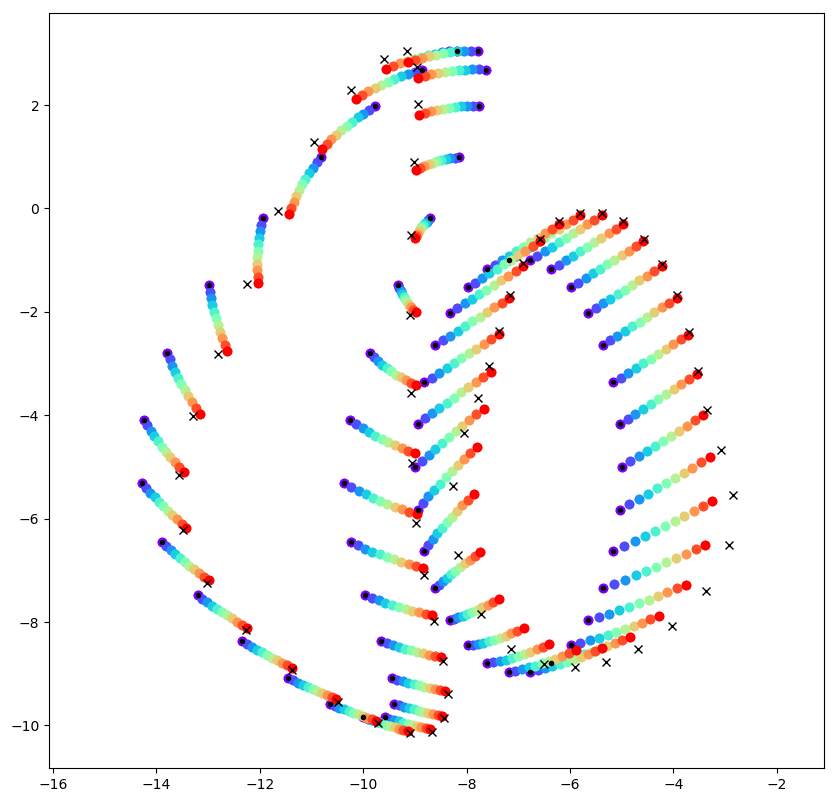

In [13]:
#%matplotlib qt5
H.module.manifold.fill_gd(X[0])
H.module.manifold.fill_cotan(X[1])

states, controls = dm.shooting.shoot_euler(H, it=10)

import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(states)))

fig_shooting = plt.figure(figsize = (10,10), dpi=100)
for s,c in zip(states, colors):
    plt.scatter(s[0][0].gd.view(-1,2)[:, 0].detach().numpy(), s[0][0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s[1][0].gd.view(-1,2)[:, 0].detach().numpy(), s[1][0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s[2][0].gd.view(-1,2)[:, 0].detach().numpy(), s[2][0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s[2][1].gd.view(-1,2)[:, 0].detach().numpy(), s[2][1].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
plt.plot(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), 'xk')
plt.plot(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), 'xk')

plt.plot(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), '.k')
plt.plot(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), '.k')

    
plt.axis('equal')
plt.show(fig_shooting)

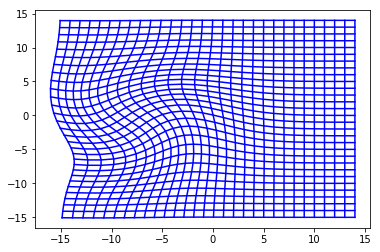

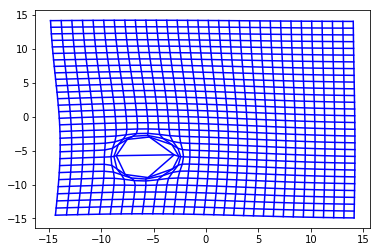

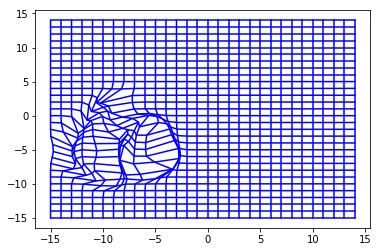

In [16]:
# Visualization of grid deformation for each submodule
nx, ny = 30, 30
sx, sy = 30, 30
x, y = torch.meshgrid([torch.arange(0, nx), torch.arange(0, ny)])
x = sx*(x.type(torch.DoubleTensor)/nx - 0.5)
y = sy*(y.type(torch.DoubleTensor)/ny - 0.5)

gridpoints = dm.usefulfunctions.grid2vec(x, y).type(torch.DoubleTensor)


phi = mm.largeDeformation(modules, states, controls, gridpoints)
x1, y1 = dm.usefulfunctions.vec2grid(phi[0], nx, ny)
x2, y2 = dm.usefulfunctions.vec2grid(phi[1], nx, ny)
x3, y3 = dm.usefulfunctions.vec2grid(phi[2], nx, ny)



fig_grid1 = mm.plot_grid( x1.detach().numpy(), y1.detach().numpy(), color = 'blue')
fig_grid2 = mm.plot_grid(x2.detach().numpy(), y2.detach().numpy(), color = 'blue')
fig_grid_bg = mm.plot_grid( x3.detach().numpy(), y3.detach().numpy(), color = 'blue')
plt.show()


In [17]:
fig_shooting.savefig('results/movingOrgans/shooting.png')
fig_source.savefig('results/movingOrgans/source.png')
fig_target.savefig('results/movingOrgans/target.png')

fig_grid1.savefig('results/movingOrgans/grid1.png')
fig_grid2.savefig('results/movingOrgans/grid2.png')
fig_grid_bg.savefig('results/movingOrgans/grid_bg.png')

In [ ]:
def test_gradcheck_Hamiltonian():
    def hamiltonian(gd, mom):
        
        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        H.geodesic_controls()
                
        return H()
    return torch.autograd.gradcheck(hamiltonian, (gd, mom), rais\gride_exception=True)

gd = gd0_tensor
mom = 1000*torch.rand(mom0_tensor.shape)


test_gradcheck_Hamiltonian()

In [ ]:
def test_gradcheck_EnergyFunctional():
    def energy(gd, mom):

        return model.EnergyFunctional(H.module, H, constr_Id,source, target, 2, reg_param).energy_tensor(gd, mom)
    return torch.autograd.gradcheck(energy, (gd, mom), raise_exception=True)

gd = gd0_tensor
mom = mom0_tensor


test_gradcheck_EnergyFunctional()

In [ ]:
def test_gradcheck_shooting():
    def shooting(gd, mom):
        
        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        
        intermediate_states, intermediate_controls = dm.shooting.shoot_euler(H, it=2)
        return H.module.manifold.unroll_cotan()
    return torch.autograd.gradcheck(shooting, (gd, mom), raise_exception=True,atol=1e-2)

test_gradcheck_shooting()

In [ ]:
def test_gradcheck_attachement():
    def attach(gd, mom):
        reg_param = 10**-3 

        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        energyfunc = model.EnergyFunctional(H.module, H, constr_Id,source, target, 2, reg_param)

        return energyfunc.attach() 
    return torch.autograd.gradcheck(attach, (gd, mom), raise_exception=True)

gd = torch.cat(H.module.manifold.unroll_gd(),0).requires_grad_().view(-1)
mom = torch.cat(H.module.manifold.unroll_cotan(),0).requires_grad_().view(-1)

test_gradcheck_attachement()

In [ ]:
def test_gradcheck_EnergyFunctional():
    def energy(gd, mom):
        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        H.module.compute_geodesic_variables(constr_Id)
        return H.module.controls[0]
    return torch.autograd.gradcheck(energy, (gd, mom), raise_exception=True)

gd = torch.cat(H.module.manifold.unroll_gd(),0).requires_grad_().view(-1)
mom = torch.cat(H.module.manifold.unroll_cotan(),0).requires_grad_().view(-1)

test_gradcheck_EnergyFunctional()

In [ ]:
def test_gradcheck_autoaction():
    def autoaction(gd, mom):
        mod.manifold.fill_gd(gd)
        mod.manifold.fill_cotan(mom)
        return mod.autoaction()
    return torch.autograd.gradcheck(autoaction, (gd, mom), raise_exception=True)

mod = data.modules[0].copy()
gd = torch.cat(mod.manifold.gd.copy())
mom = torch.cat(mod.manifold.cotan.copy())

gd.requires_grad
mom.requires_grad

test_gradcheck_autoaction()